In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from analysis_funcs import *
from external_flux import *

In [3]:
import glob
import re

In [4]:
getobmt = lambda x: int(re.search("(?<=OBMT_START_)[0-9]+",x).group(0))

In [5]:
def load_fluxfile(filename):
    dat = np.loadtxt(filename)
    t = dat[:,0]
    f = dat[:,1]
    err = dat[:,2]
    
    return t,f,err

# External

In [121]:
t_goes, f_goes = read_flux_external(sorted(glob.glob('../datasets/external/GOES/GOES_20*.txt')))
t_goes = t_goes.mjd

t_ace, f_ace = read_flux_external(sorted(glob.glob('../datasets/external/ACE/ACE_20*.txt')))
t_ace = t_ace.mjd

# Fluxes in SM

In [7]:
(t_P,f_P,err_P) = PPE_flux('../datasets/PPE/ASD4_Counters_FOV1_ROW1.dat')

In [8]:
#(t_S,n_S,f_S,err_S) = fits_flux(allpaths)

# for SM: load flux for every chip at once
t_S = []
f_S = []
err_S = []

for fov in [1,2]:
    for row in range(1,8):
        t,f,err = load_fluxfile("../output/FLUX/SM-SIF{}_{}_flux.txt".format(fov,row))
        t_S += list(t)
        f_S += list(f)
        err_S += list(err)
        
# then sort by OBMT
sorter = sorted((zip(t_S,f_S,err_S)),key = lambda x: x[0])

t_S = np.array([s[0] for s in sorter])
f_S = np.array([s[1] for s in sorter])
err_S = np.array([s[2] for s in sorter])

# BAM

In [9]:
t_B1_full,f_B1_full,err_B1_full = load_fluxfile("../output/FLUX/BAM-OBS1_flux.txt")
#t_B2_full,f_B2_full,err_B2_full = load_fluxfile("../output/FLUX/BAM-OBS2_flux.txt")

In [10]:
t_BS1, f_BS1, err_BS1 = load_fluxfile("../output/FLUX/BAM-SIF1_flux.txt")

In [11]:
def rebin_arrs(arrs,binning):
    """
    Rebin every array out of the iterable arr by averaging over binning samples
    """
    
    if binning==1:
        return arrs
    
    out = []
    
    for a in arrs:
        len_rebin = len(a)//binning  # integer division! 
                                     # we want to round down, so we ignore the last up to binning-1 samples
        a_rebin = np.reshape(a[:len_rebin*binning], (len_rebin,binning))
        a_rebin = np.mean(a_rebin,axis=1)
        
        out.append(a_rebin)

    return tuple(out)

In [12]:
rebin_fac = 10

t_B1,f_B1,err_B1 = rebin_arrs((t_B1_full,f_B1_full,err_B1_full), rebin_fac)
#t_B2,f_B2,err_B2 = rebin_arrs((t_B1_full,f_B1_full,err_B1_full), rebin_fac)

In [13]:
def MJD_cutout(t,f,err,mjd_start,mjd_stop,stepping=1):
    """
    Return time [mjd], flux and error within a certain inclusive range of mjd.
    By setting stepping=n, this will only return every nth sample
    """
    t_mjd = OBMT_apyTime(t).mjd
    retrange = np.logical_and(t_mjd>=mjd_start, t_mjd<=mjd_stop)
    
    if stepping < 1:
        stepping = 1
    
    return t_mjd[retrange][::stepping], f[retrange][::stepping], err[retrange][::stepping]

In [108]:
def flareplot(tstart,tstop,stepping,ybam=(1,100),ysm=(1,100),yext=(.05,500),log=True):
    t1,f1,err1 = MJD_cutout(t_B1,f_B1,err_B1,tstart,tstop,stepping)
    t2,f2,err2 = MJD_cutout(t_BS1,f_BS1,err_BS1,tstart,tstop,1)
    t3,f3,err3 = MJD_cutout(t_P,f_P,err_P,   tstart,tstop,stepping)
    t4,f4,err4 = MJD_cutout(t_S,f_S,err_S,   tstart,tstop,1)

    fig, (axbam, axsm, axext) = plt.subplots(nrows=3,sharex=True)

    axbam.errorbar(t1, f1, yerr=err1*0, linestyle='', marker='x', color='xkcd:red', label="BAM-OBS1")
    if len(t2>0):
        axbam.errorbar(t2, f2, yerr=err2*0, linestyle='', marker='x', color='xkcd:faded blue', label="BAM-SIF1")
    
    axsm.errorbar(t4, f4, yerr=err4, linestyle='', marker='x', color='xkcd:tree green', label="SM-SIF")
    axsm.errorbar(t3, f3, yerr=err3, linestyle='', marker='x', color='xkcd:amethyst', label="SM-PPE")
    
    #axext.plot(t_goes[::30], f_goes[2][::30], linestyle='', marker='x', color='xkcd:amethyst', label="GOES > 10 MeV")
    axext.plot(t_ace, f_ace[0], linestyle='', marker='x', color='xkcd:red', label="ACE > 10 MeV")
    axext.plot(t_ace, f_ace[1], linestyle='', marker='x', color='xkcd:faded blue', label="ACE > 30 MeV")

    # logarithmic axes
    if log==True:
        axbam.set_yscale('log')
        axsm.set_yscale('log')
        axext.set_yscale('log')
    
    axbam.legend(loc='upper right')
    axsm.legend(loc='upper right')
    axext.legend(loc='upper right')

    axbam.set_ylim(ybam)
    axbam.set_ylabel("Flux [particles/s/cm^2]")

    axsm.set_ylim(ysm)
    axsm.set_ylabel("Flux [particles/s/cm^2]")

    axext.set_ylim(yext)
    axext.set_ylabel("Flux [particles/sr/s/cm^2]")
    axext.set_xlabel("MJD")

    axbam.set_xlim(tstart,tstop)

    plt.gcf().set_size_inches(20,10)

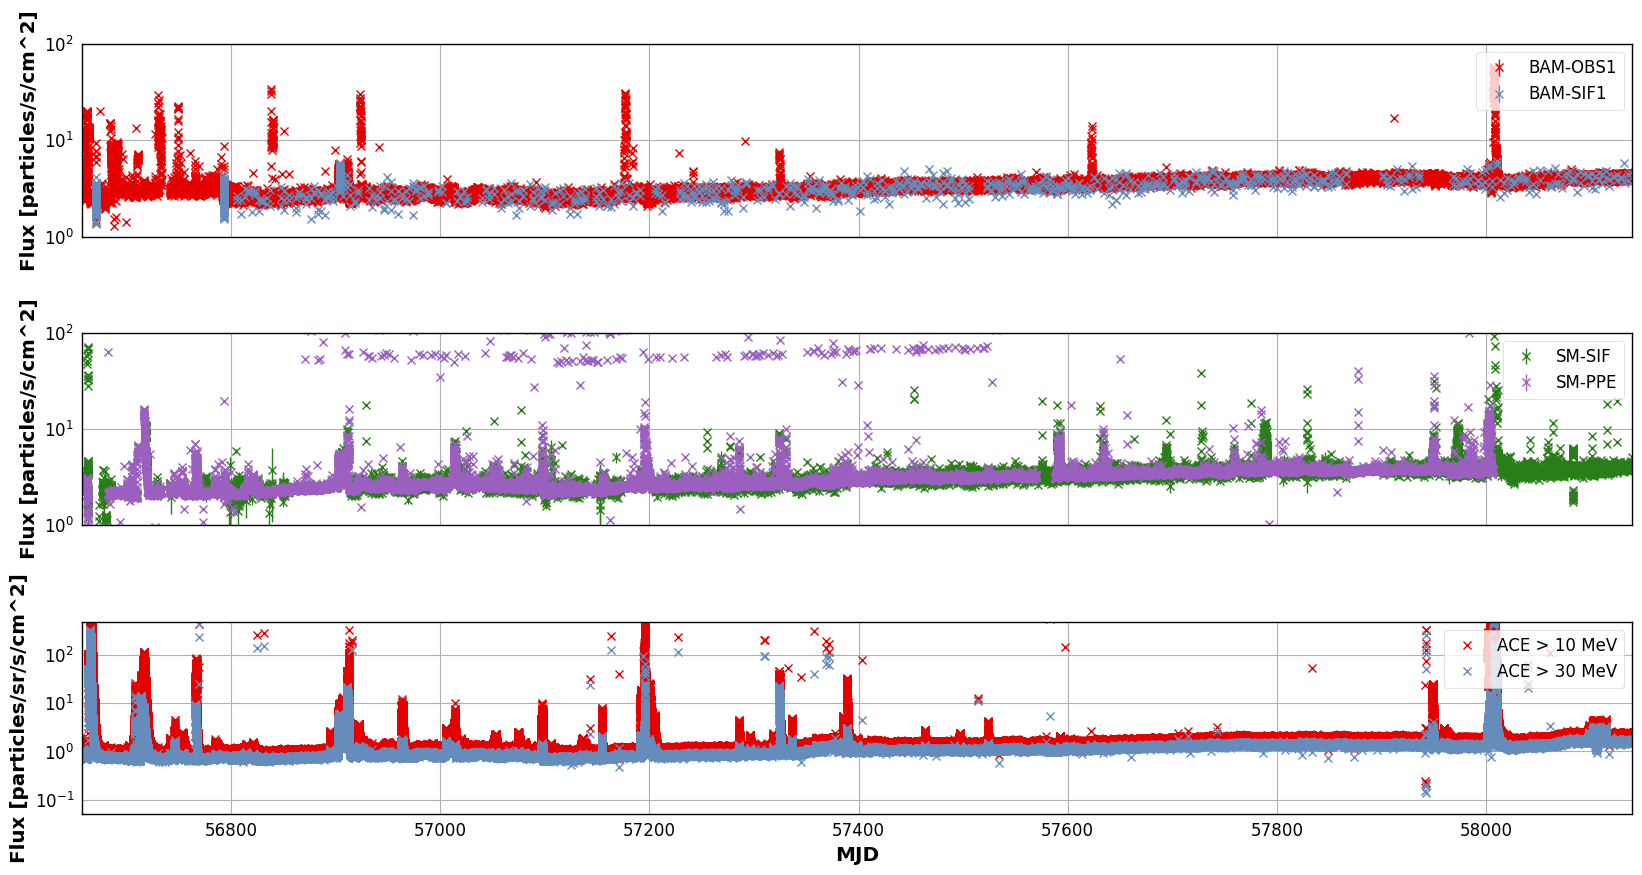

In [122]:
#tstart,tstop  = (57150,57200)
#tstart,tstop  = (58000,58015) # Sept '17 Flare
#tstart,tstop = (57945,57955)  # Jul '17 Flare
#tstart,tstop = (56901,56915) # Sept '14
#tstart,tstop = (56880,57050)
#tstart,tstop = (57930,57945) # quiet period
#tstart,tstop = (57632,57636) # strong stray light modulation


flareplot(min(OBMT_apyTime(t_S).mjd),max(OBMT_apyTime(t_S).mjd),10)

Let's look at a few individual flares

We'll look at periods of 200 days and then zoom in on whatever we find

## Beginning - 56800

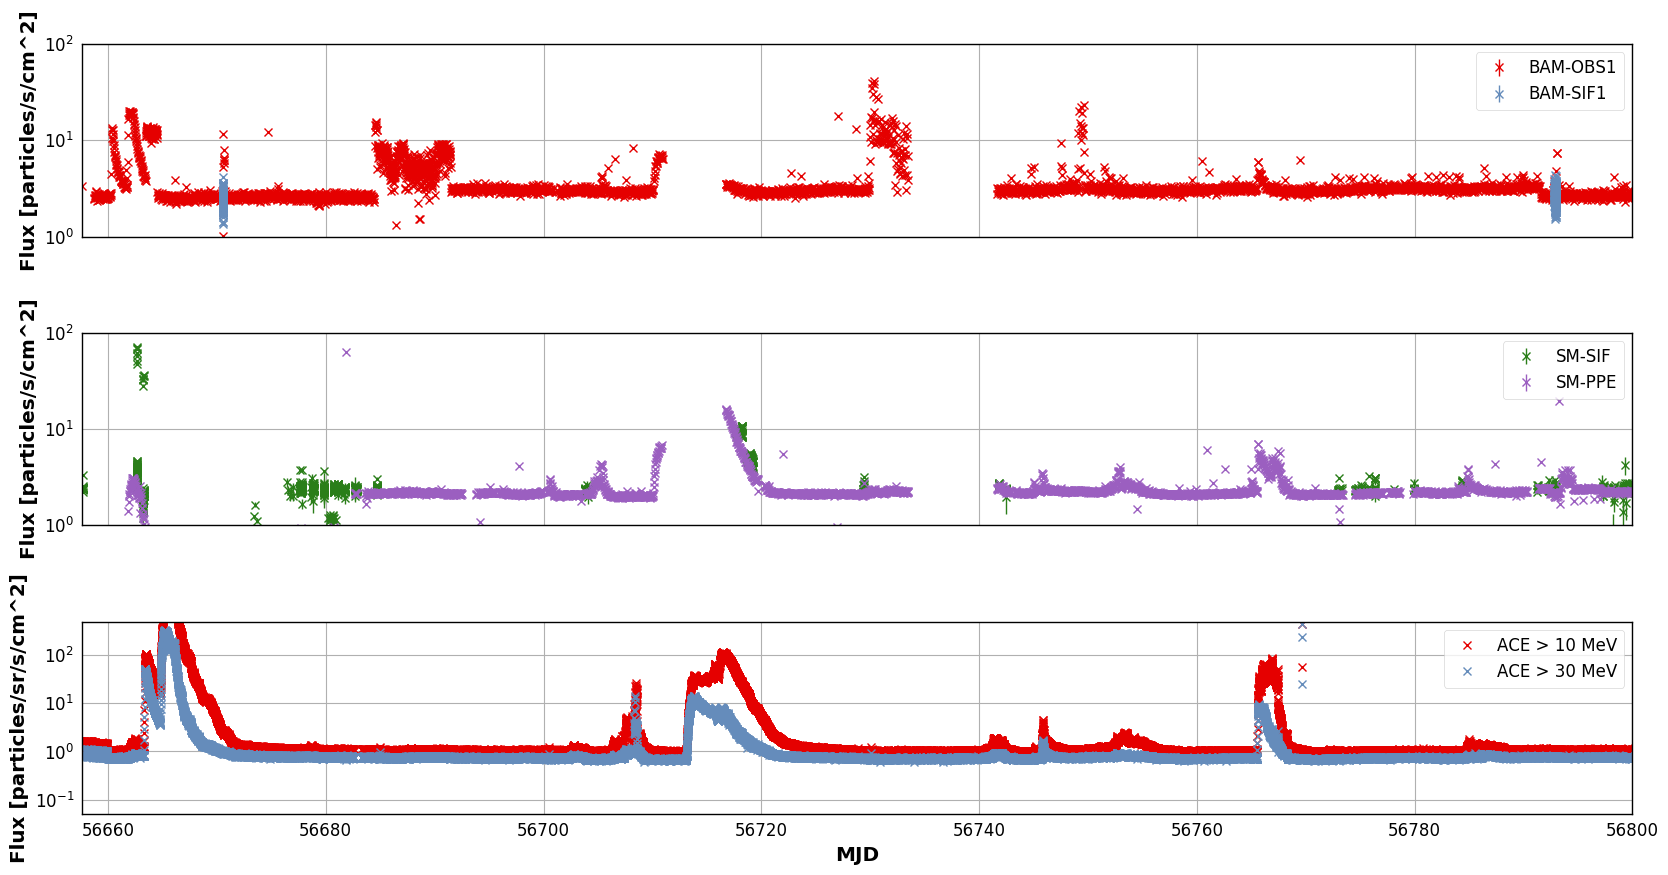

In [18]:
flareplot(min(OBMT_apyTime(t_B1).mjd),56800,10)

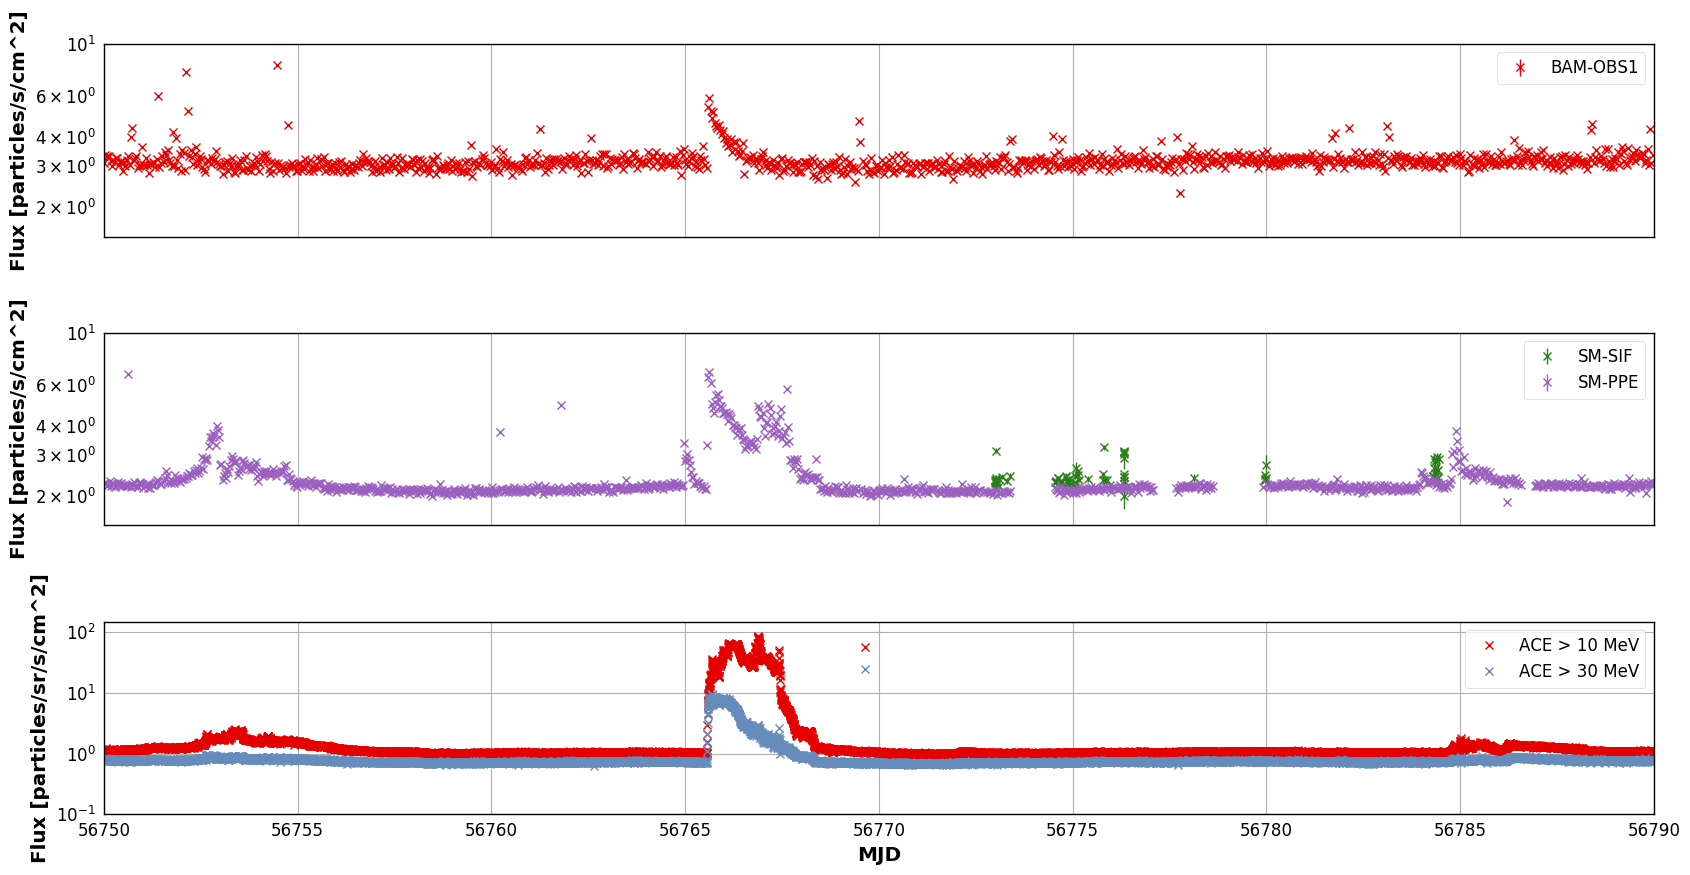

In [112]:
flareplot(56750,56790,10,ybam=(1.5,10),ysm=(1.5,10),yext=(.1,150))

Good demonstratio of BAM vs SM in regards to energy. Interesting dip in the middle of SM?

## 56800 - 57000

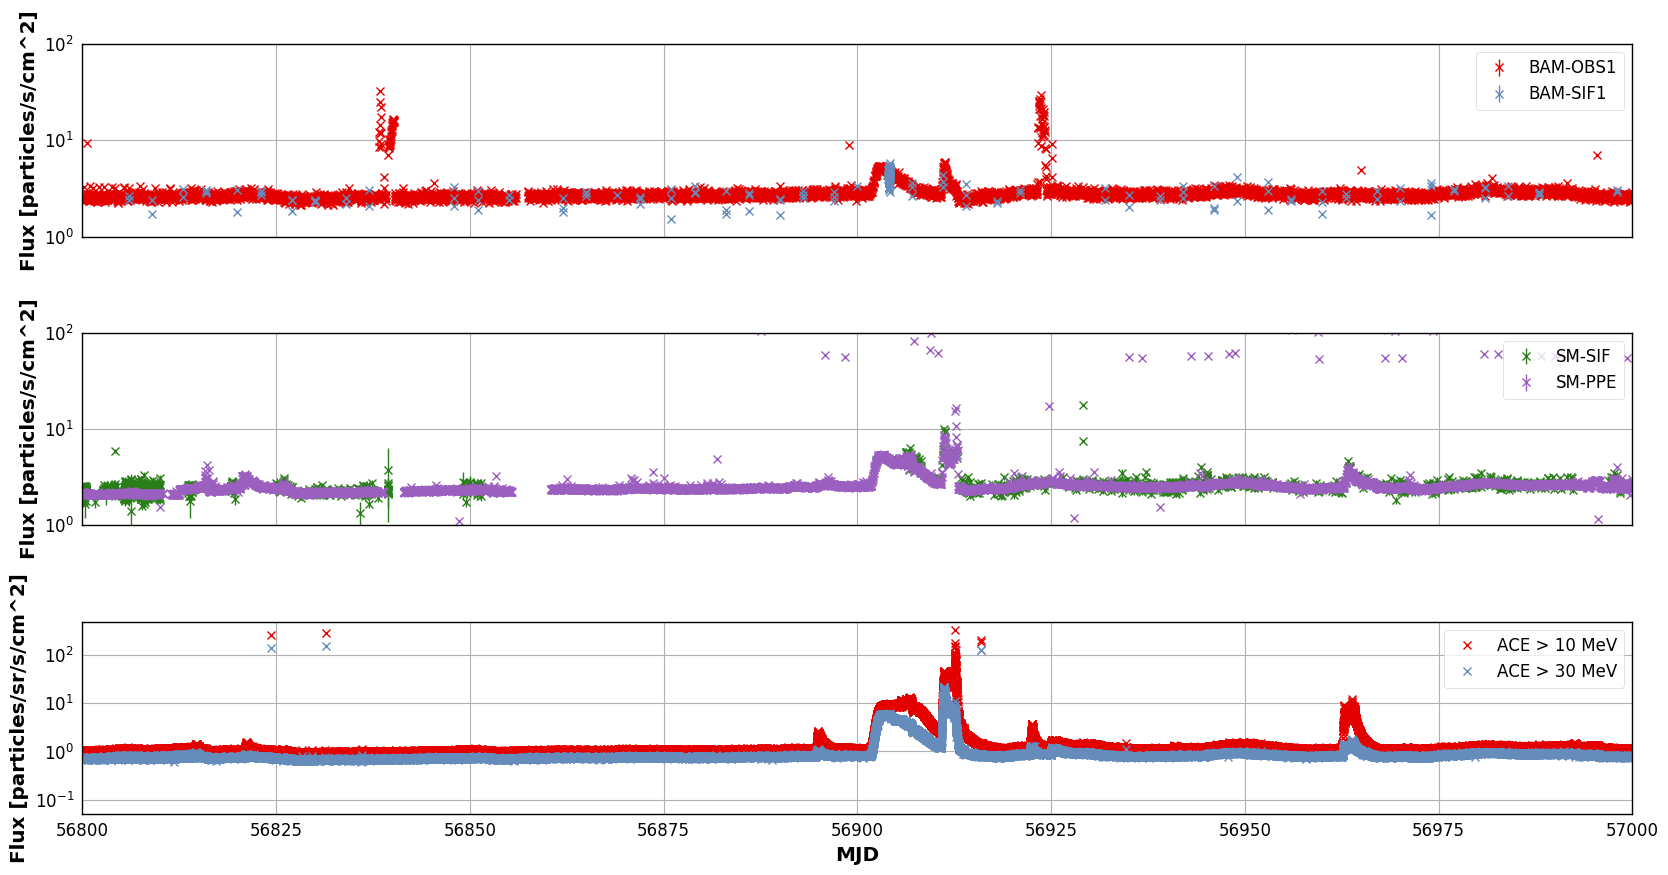

In [93]:
flareplot(56800,57000,10)

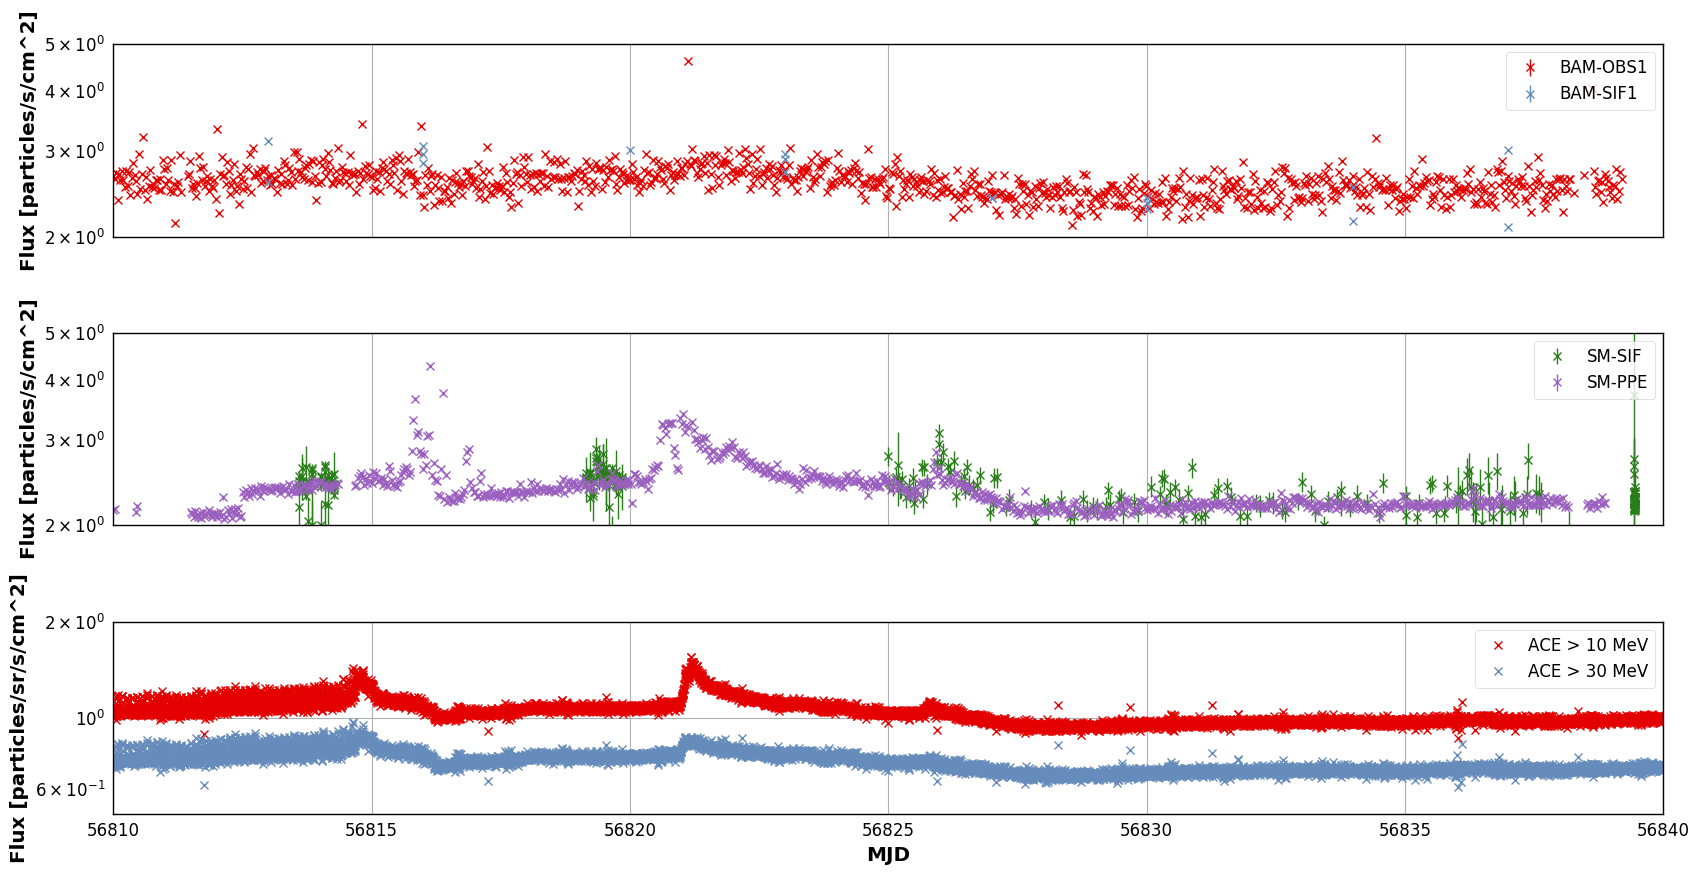

In [114]:
flareplot(56810,56840,10,ybam=(2,5),ysm=(2,5),yext=(.5,2),log=True)

There seem to be some arrival time delays here?

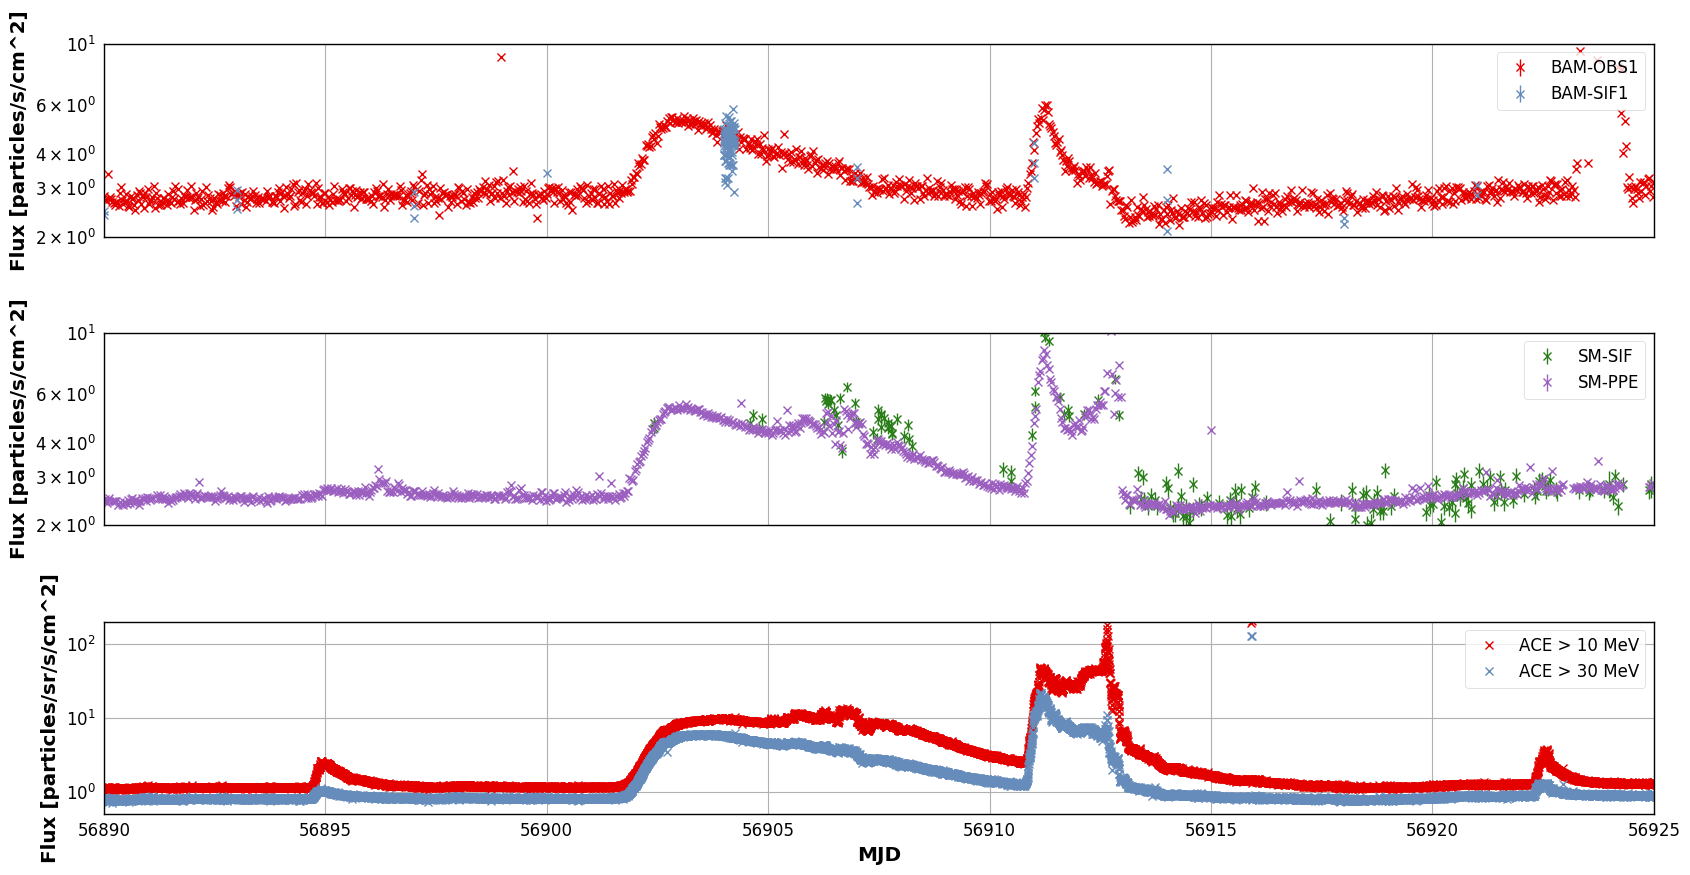

In [134]:
flareplot(56890,56925,10,ybam=(2,10),ysm=(2,10),yext=(.5,200))

Nice how SM also sees a 'wiggle' in the precursor. The double-peaked thing sould be interesting to study.

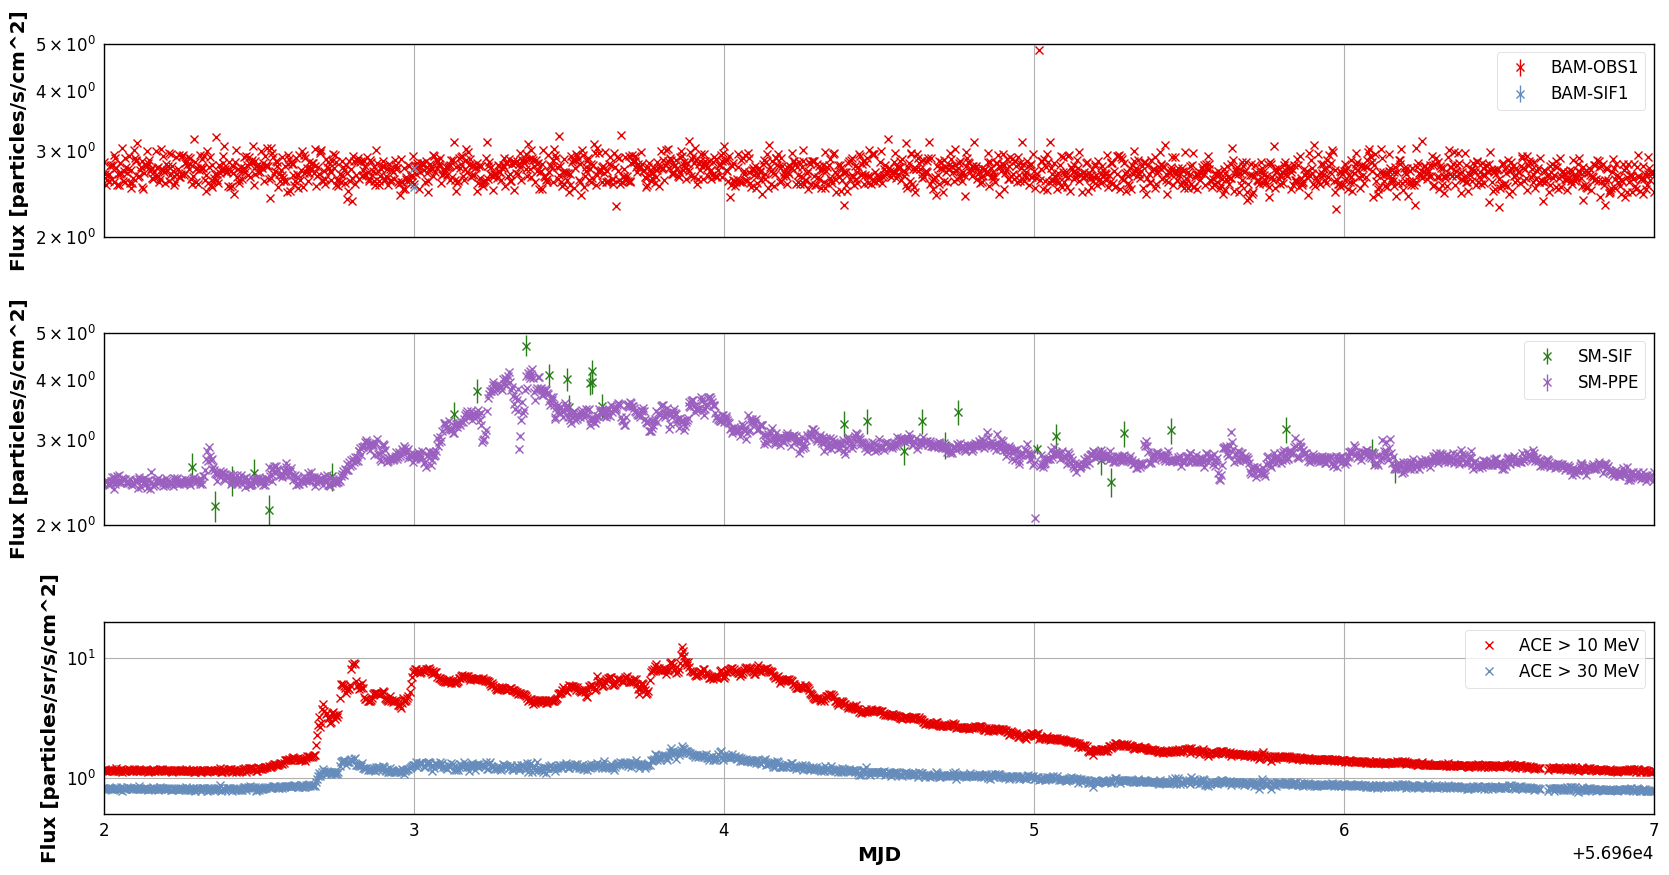

In [118]:
flareplot(56962,56967,1,ybam=(2,5),ysm=(2,5),yext=(.5,20),log=True)

This also looks like there's some different timing, no?

## 57000 - 57200

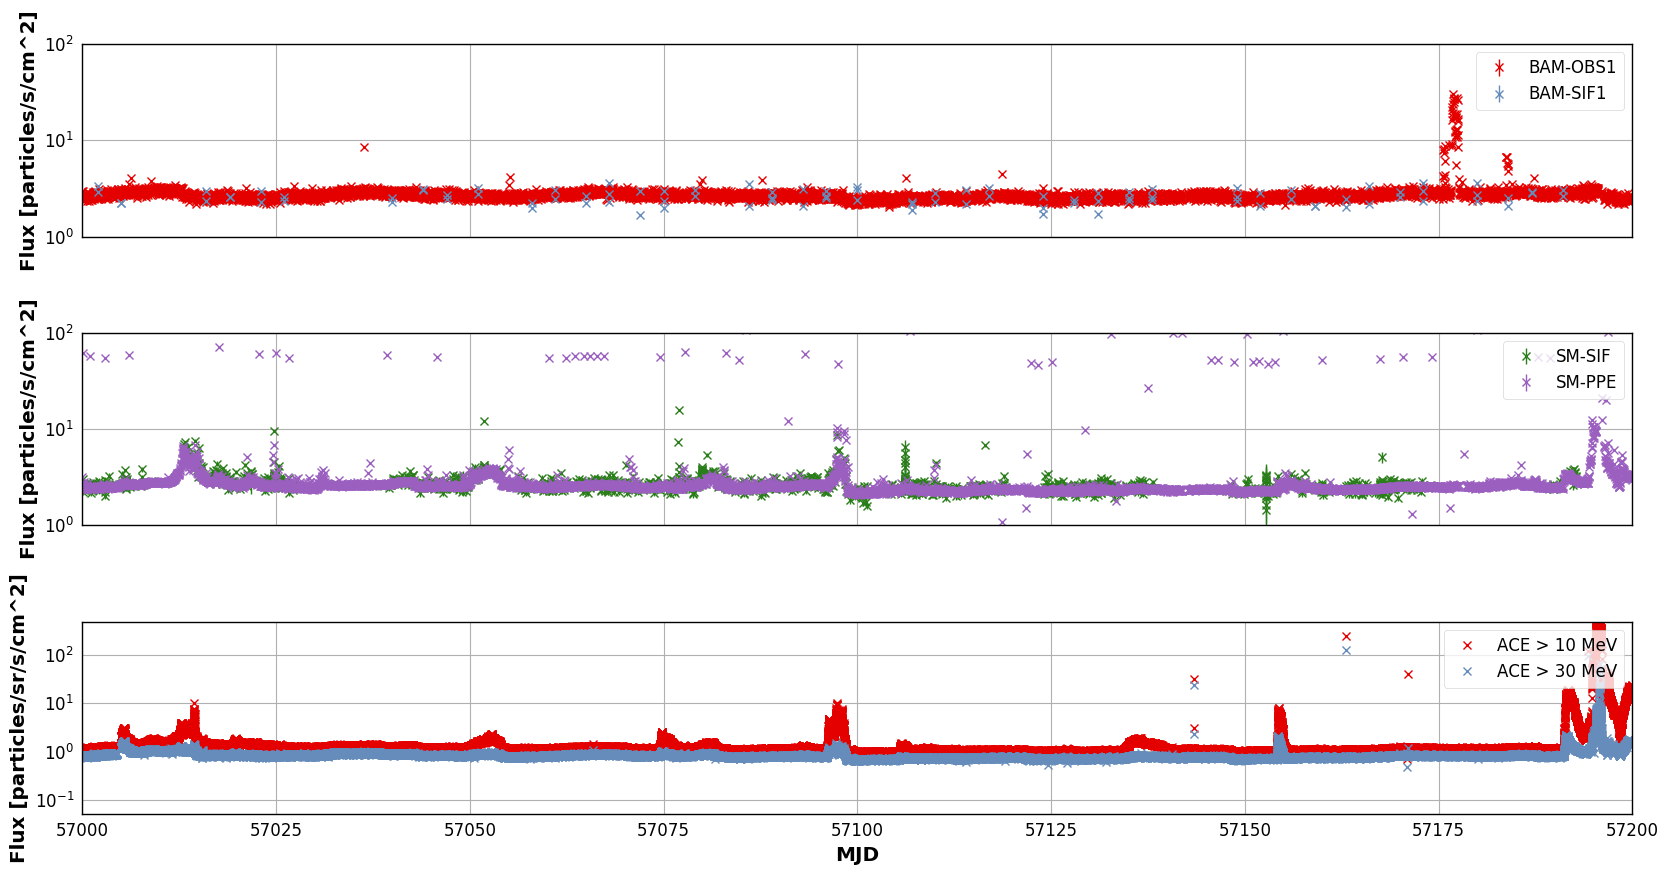

In [21]:
flareplot(57000,57200,10)

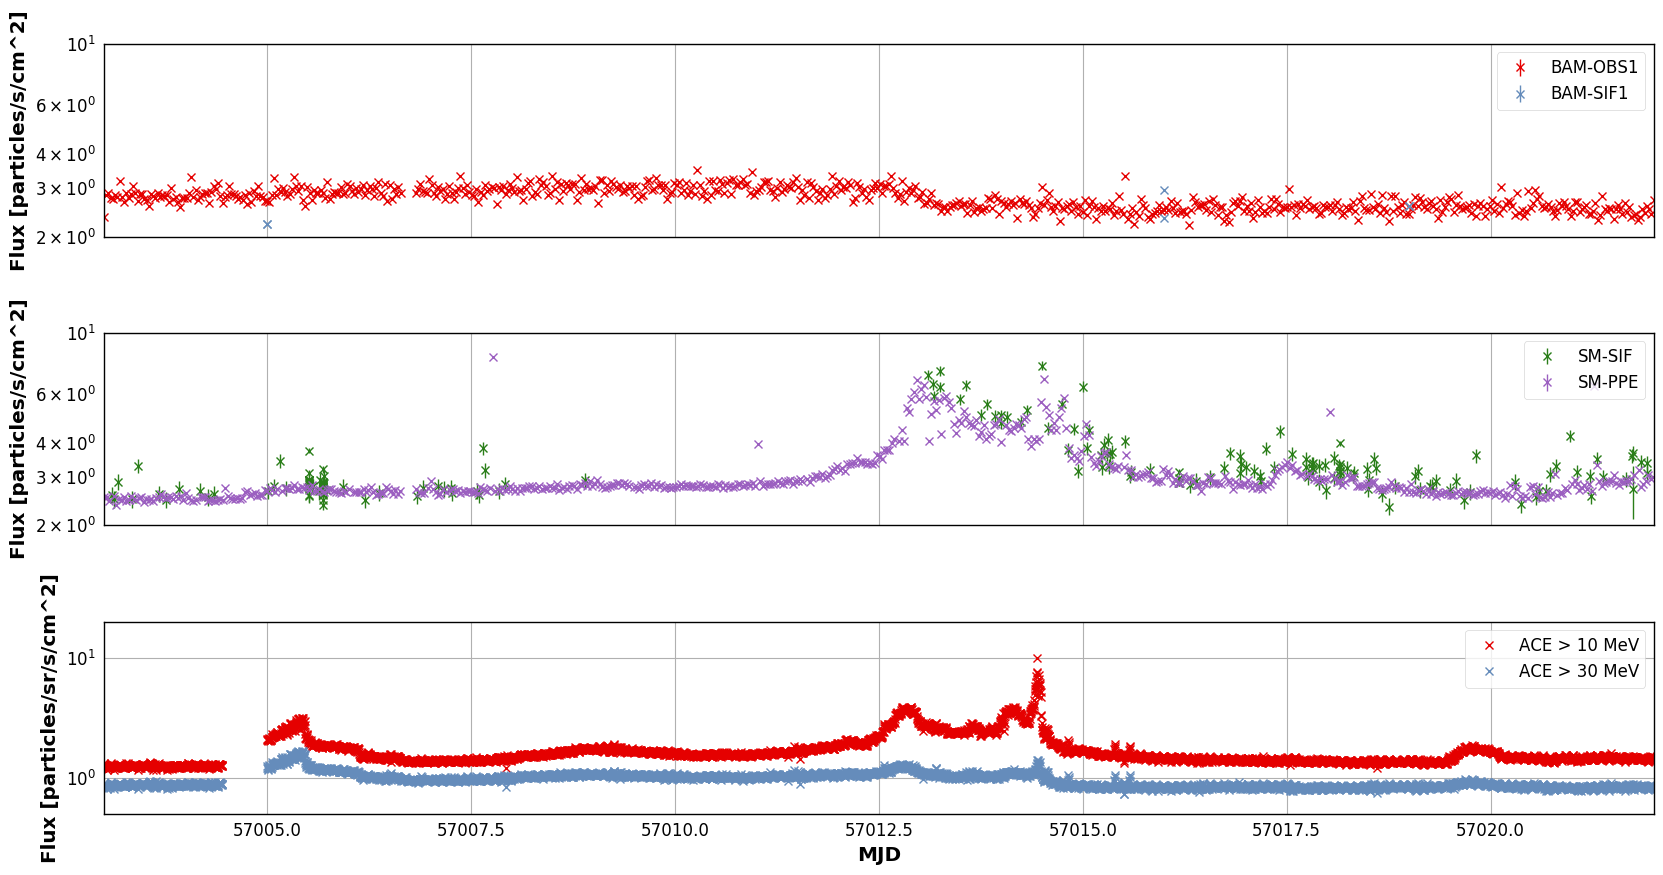

In [58]:
flareplot(57003,57022,10,ybam=(2,10),ysm=(2,10),yext=(.5,20))

Flare around 57005 is not picked up at all?

BAM actually does see some flaring, although the point at which the countrates go down is strange.

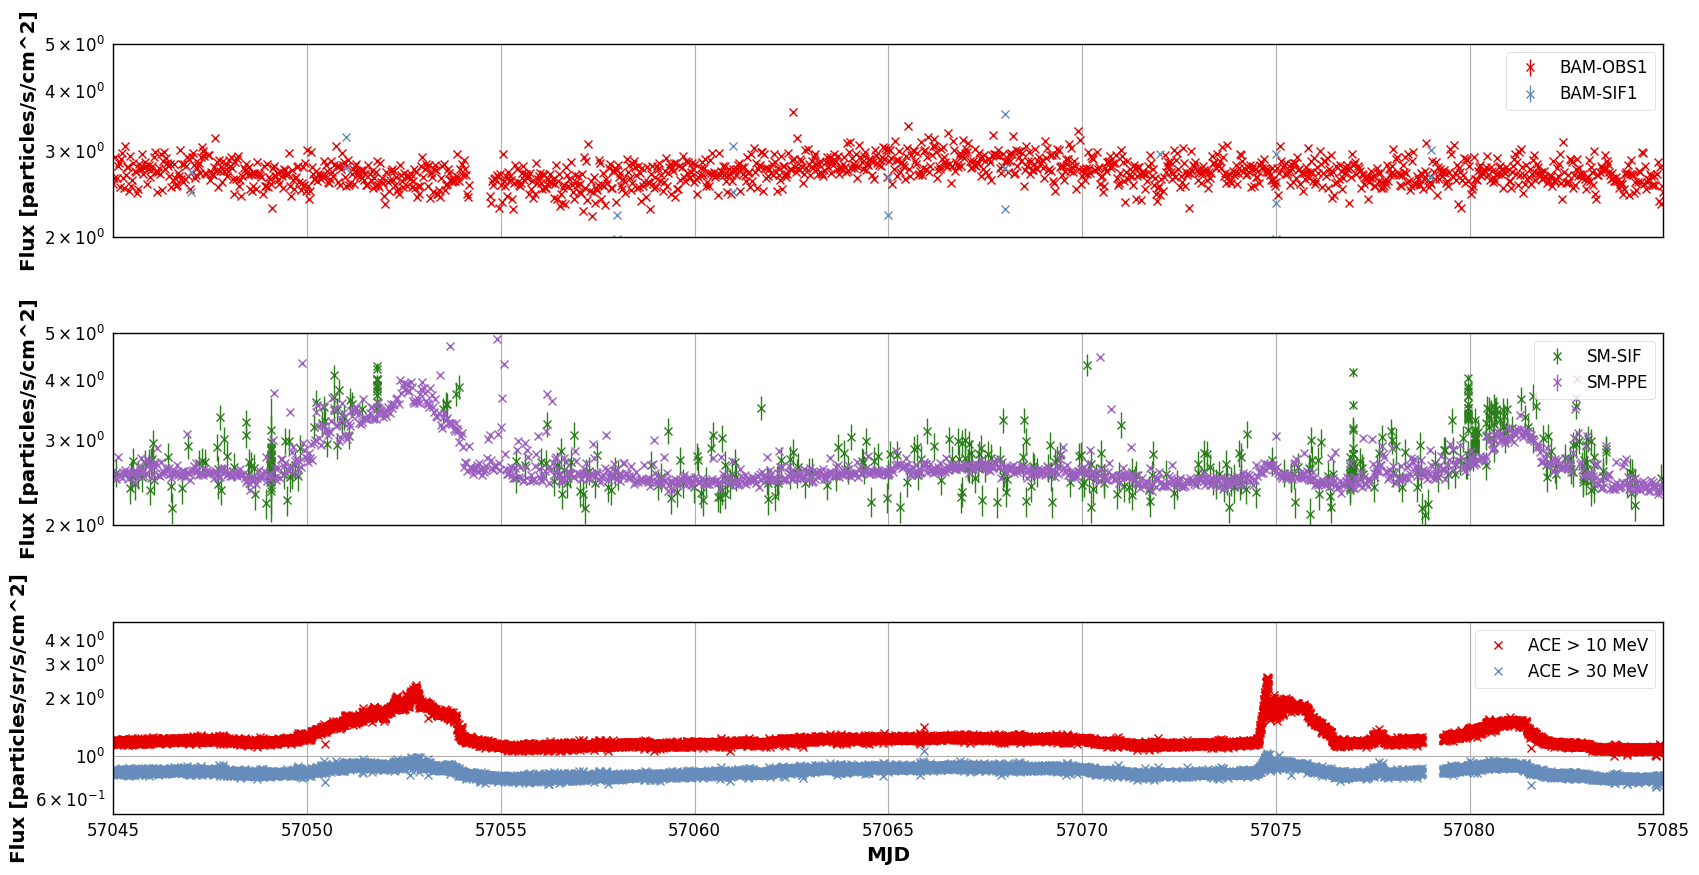

In [65]:
flareplot(57045,57085,10,ybam=(2,5),ysm=(2,5),yext=(.5,5))

The second flare is really interesting - SM vs ACE show different relative peaks.

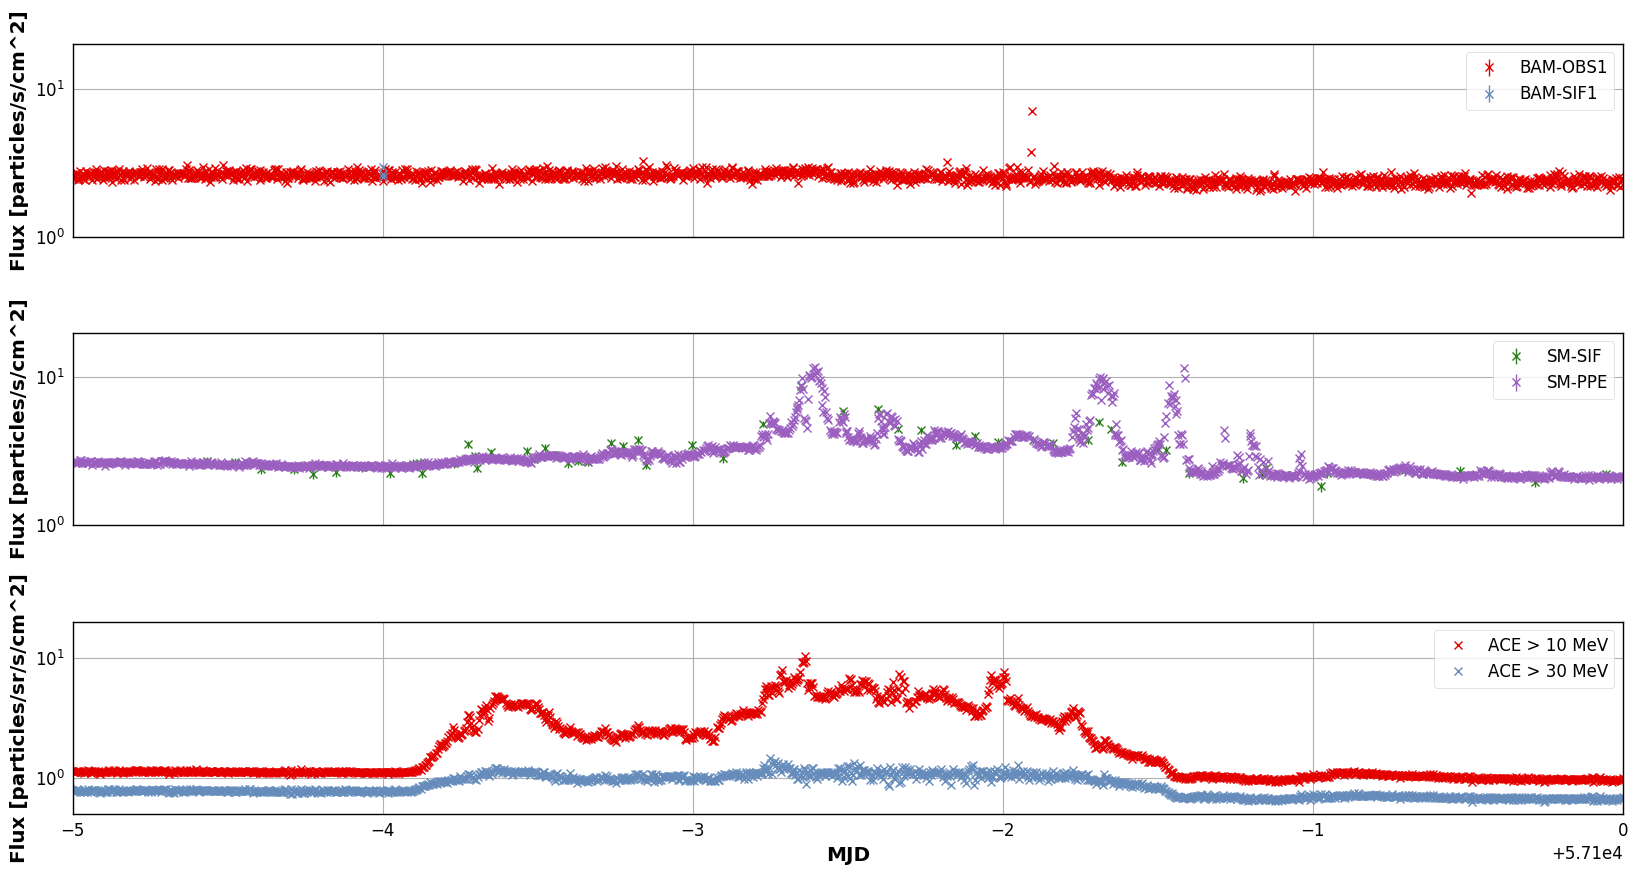

In [120]:
flareplot(57095,57100,1,ybam=(1,20),ysm=(1,20),yext=(.5,20),log=True)

Timing difference?

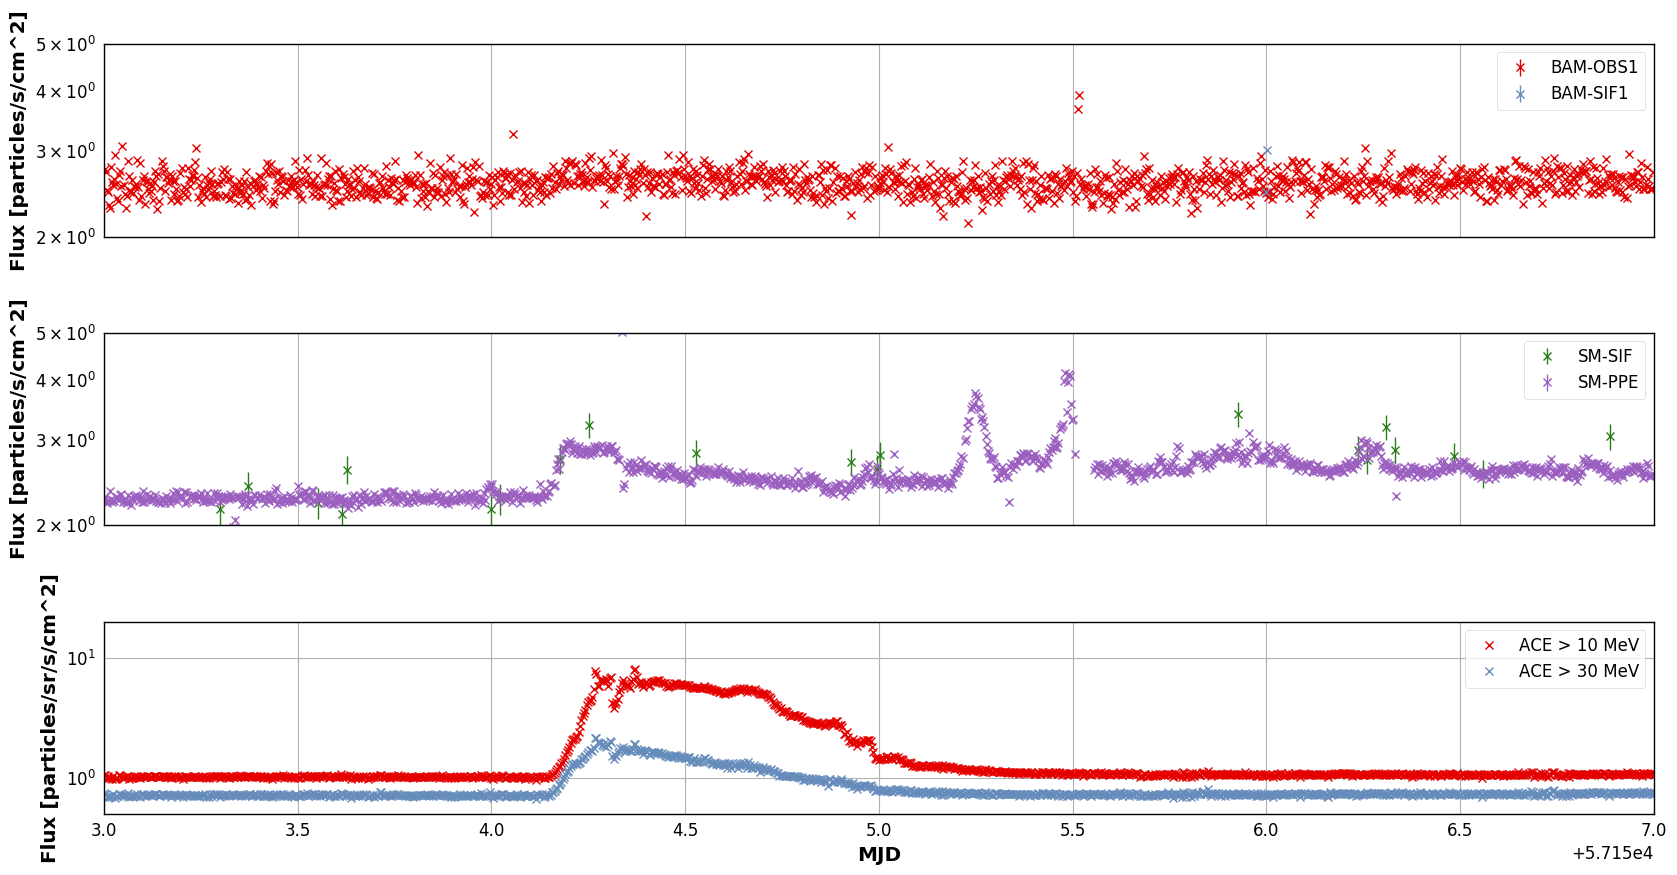

In [73]:
flareplot(57153,57157,1,ybam=(2,5),ysm=(2,5),yext=(.5,20))

Strange structure after the flare proper in SM

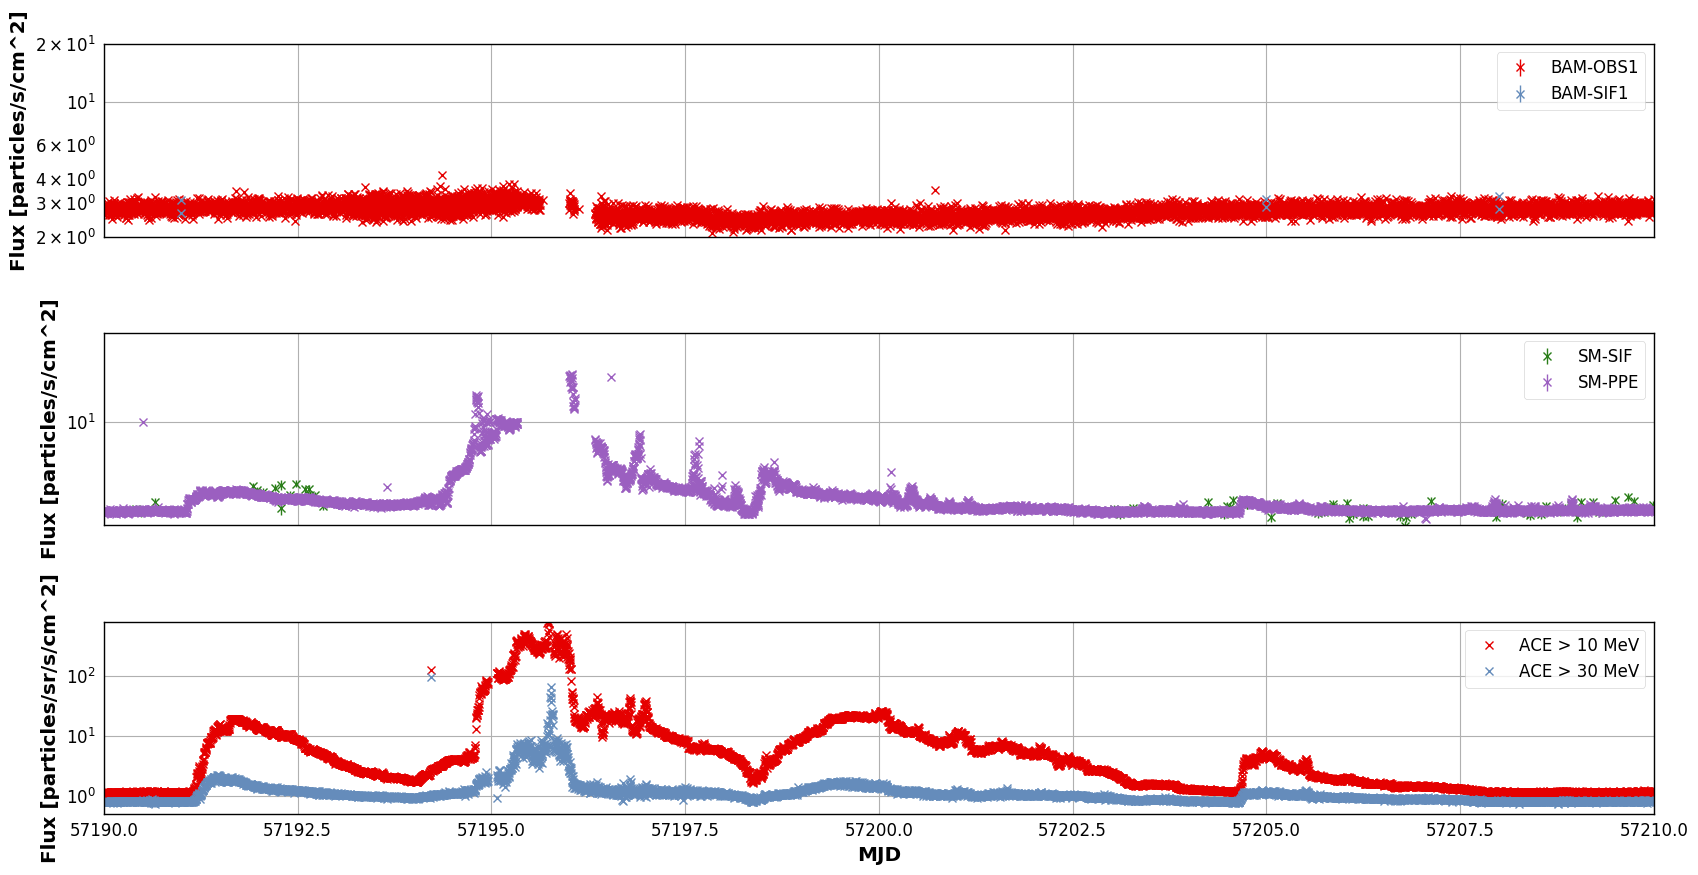

In [128]:
flareplot(57190,57210,1,ybam=(2,20),ysm=(2,40),yext=(.5,800),log=True)

An annoying data gap...

## 57200 - 57400

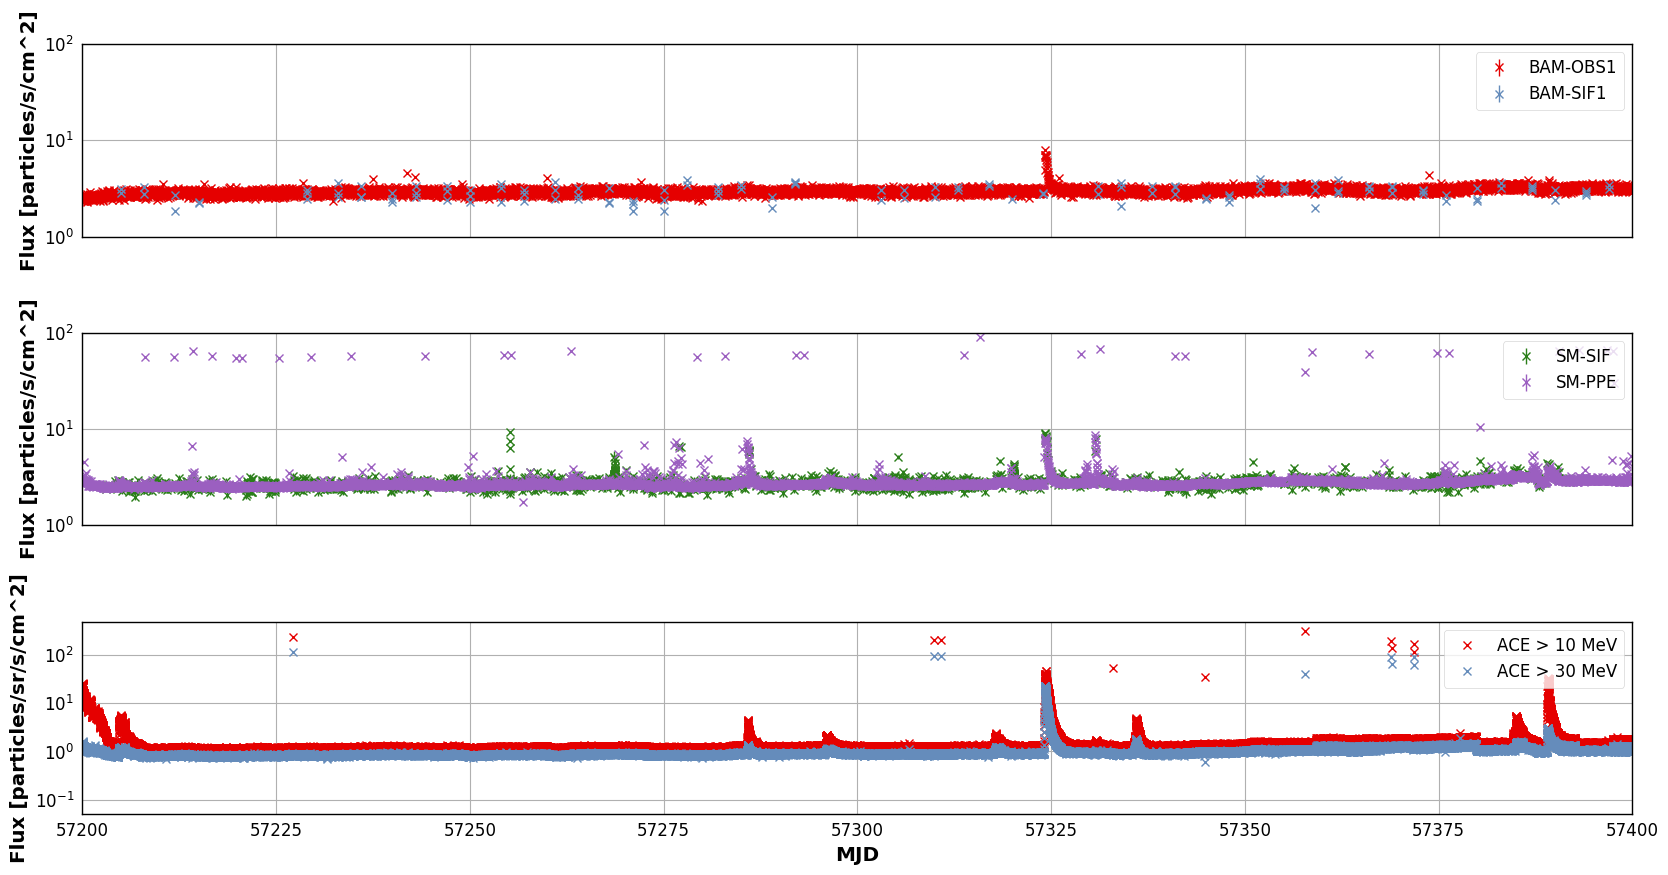

In [22]:
flareplot(57200,57400,10)

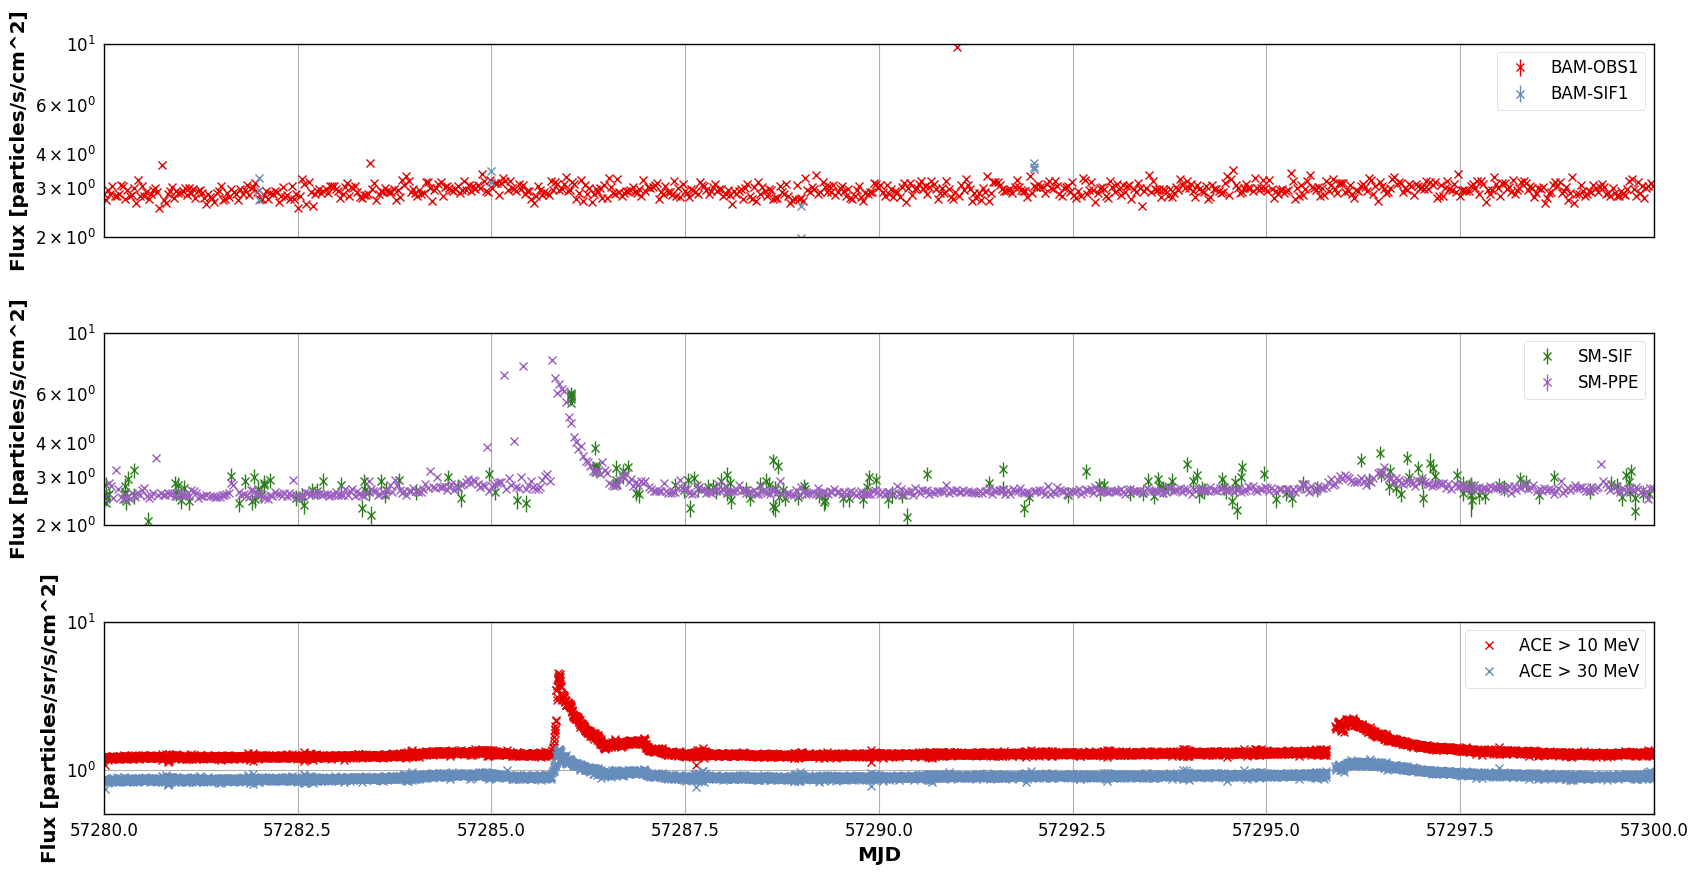

In [83]:
flareplot(57280,57300,10,ybam=(2,10),ysm=(2,10),yext=(.5,10))

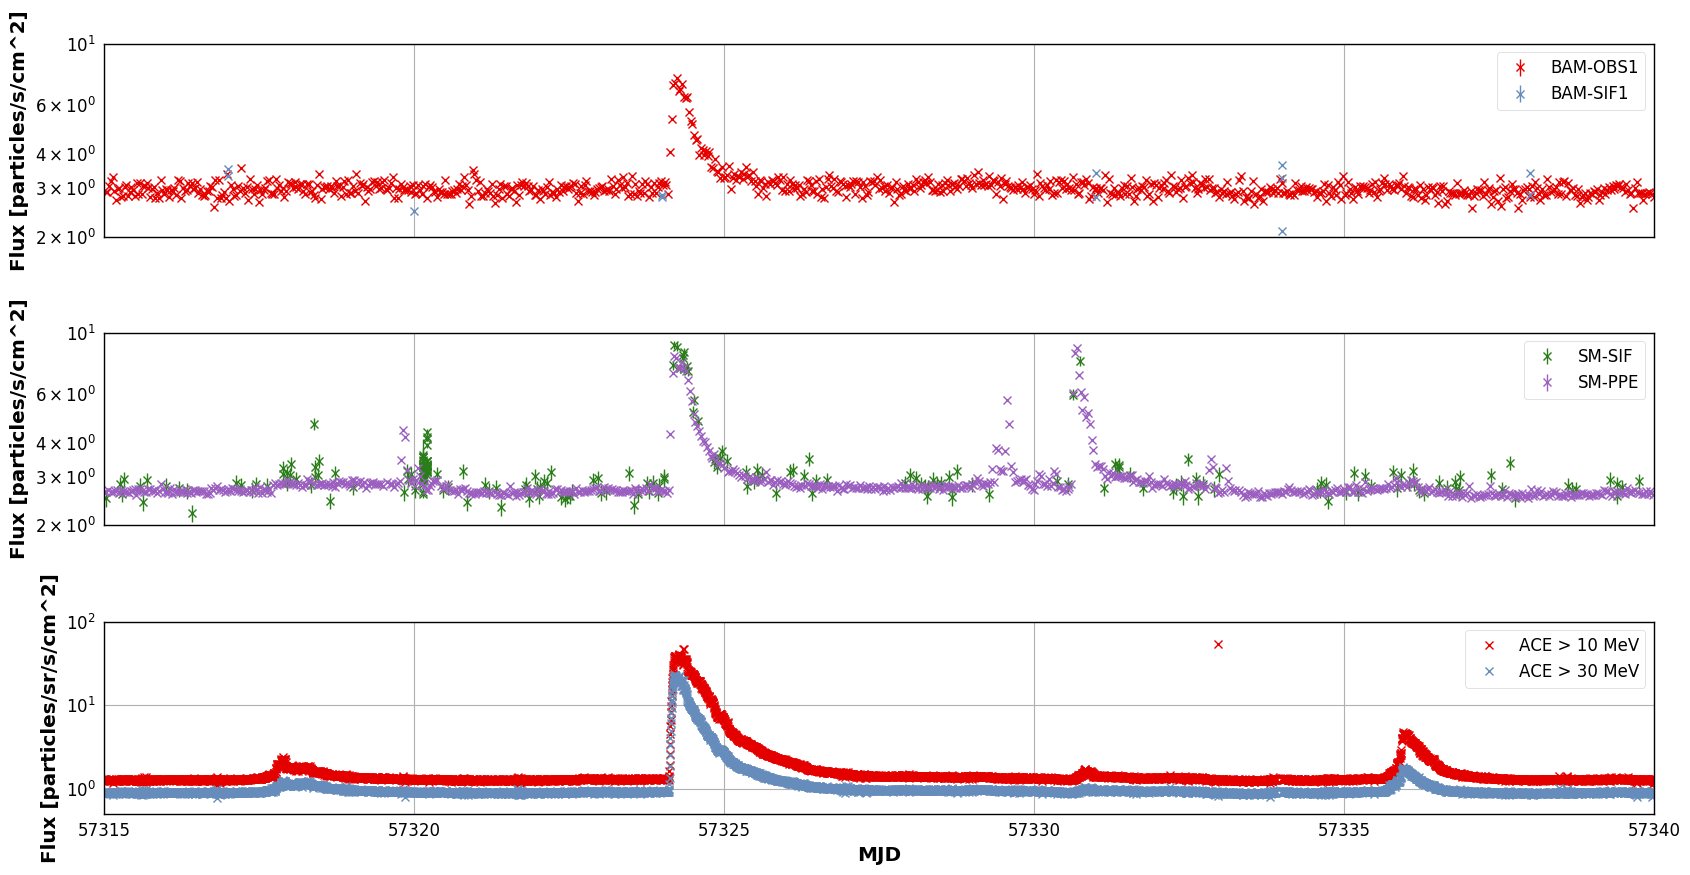

In [85]:
flareplot(57315,57340,10,ybam=(2,10),ysm=(2,10),yext=(.5,100))

Very interesting how the first flare is picked up, but the second almost not at all

Is the peak in the middle for SM just some stars?

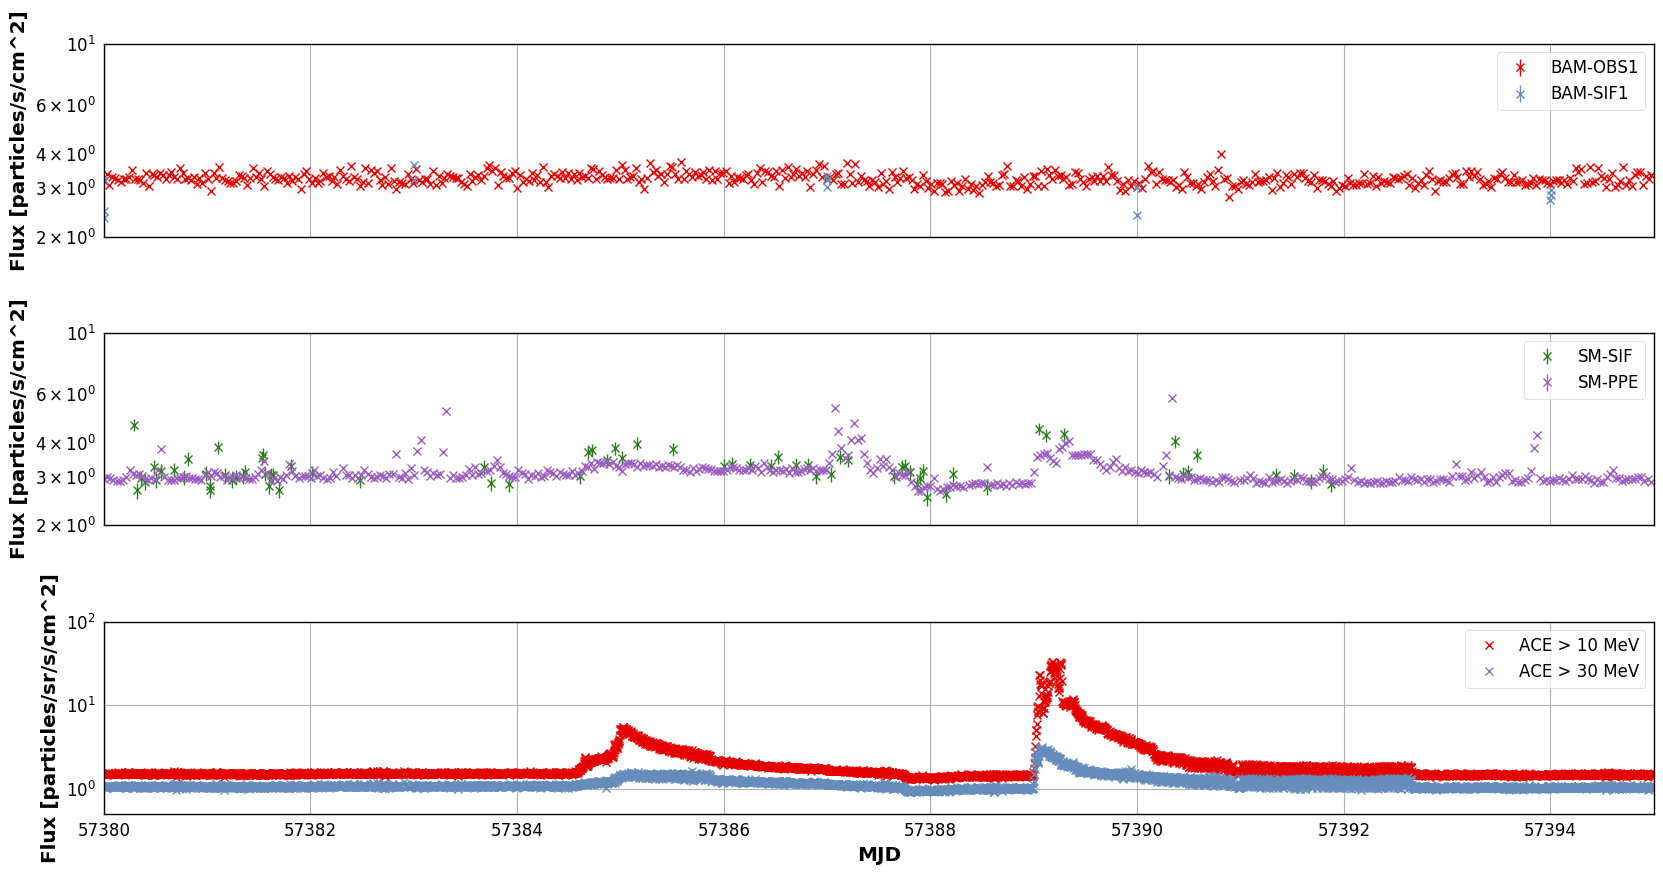

In [87]:
flareplot(57380,57395,10,ybam=(2,10),ysm=(2,10),yext=(.5,100))

SM looks weird here

## 57400 - 57600

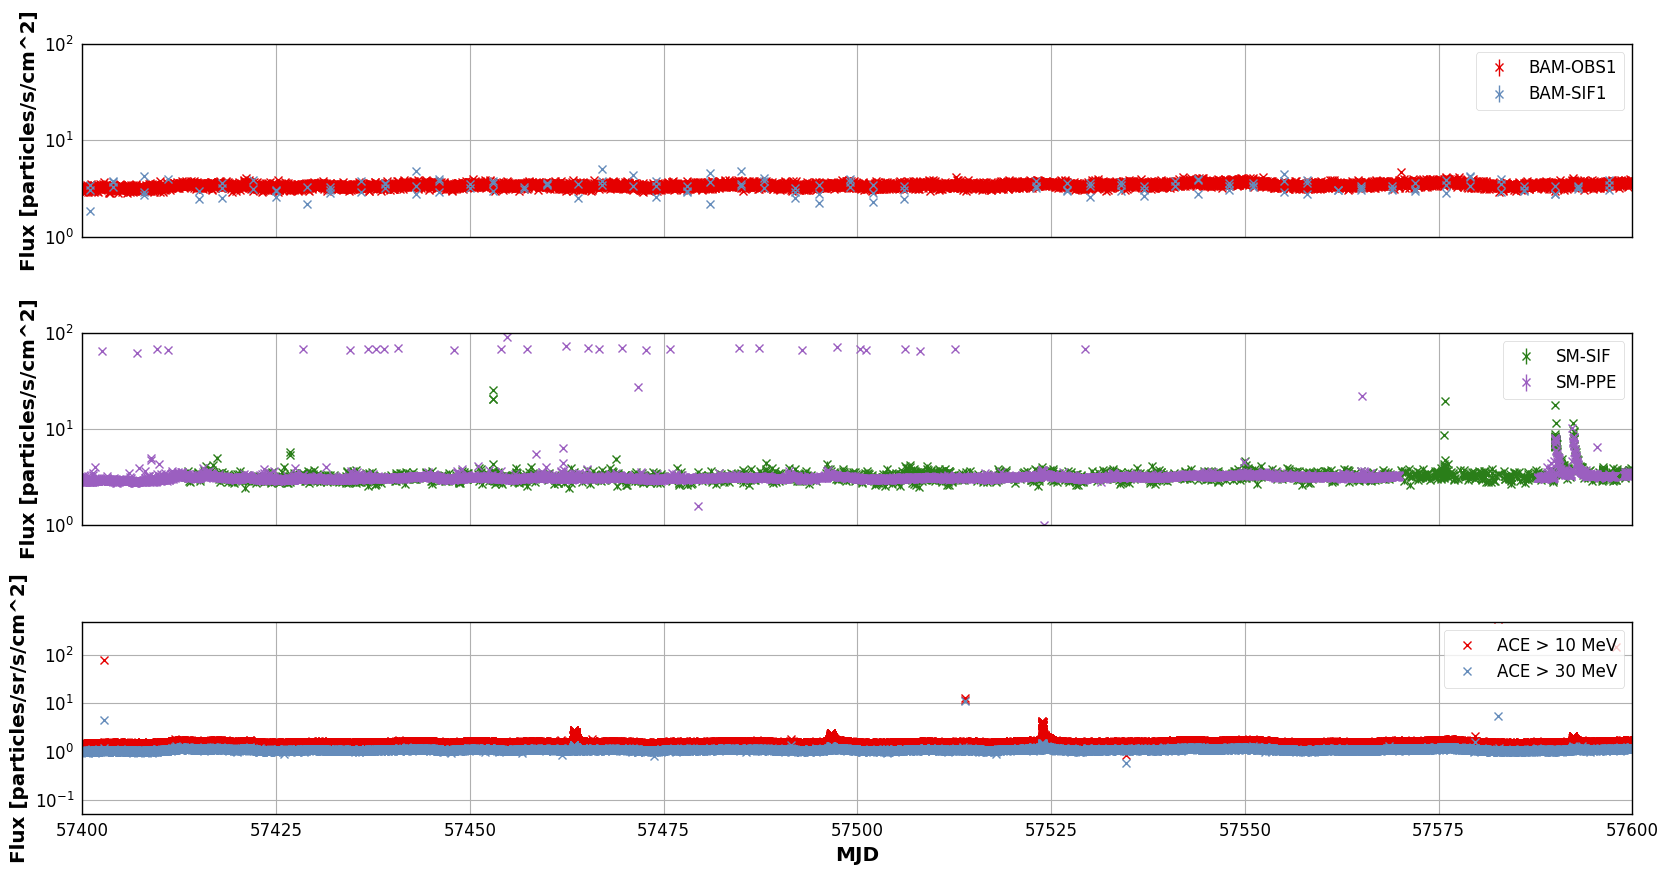

In [23]:
flareplot(57400,57600,10)

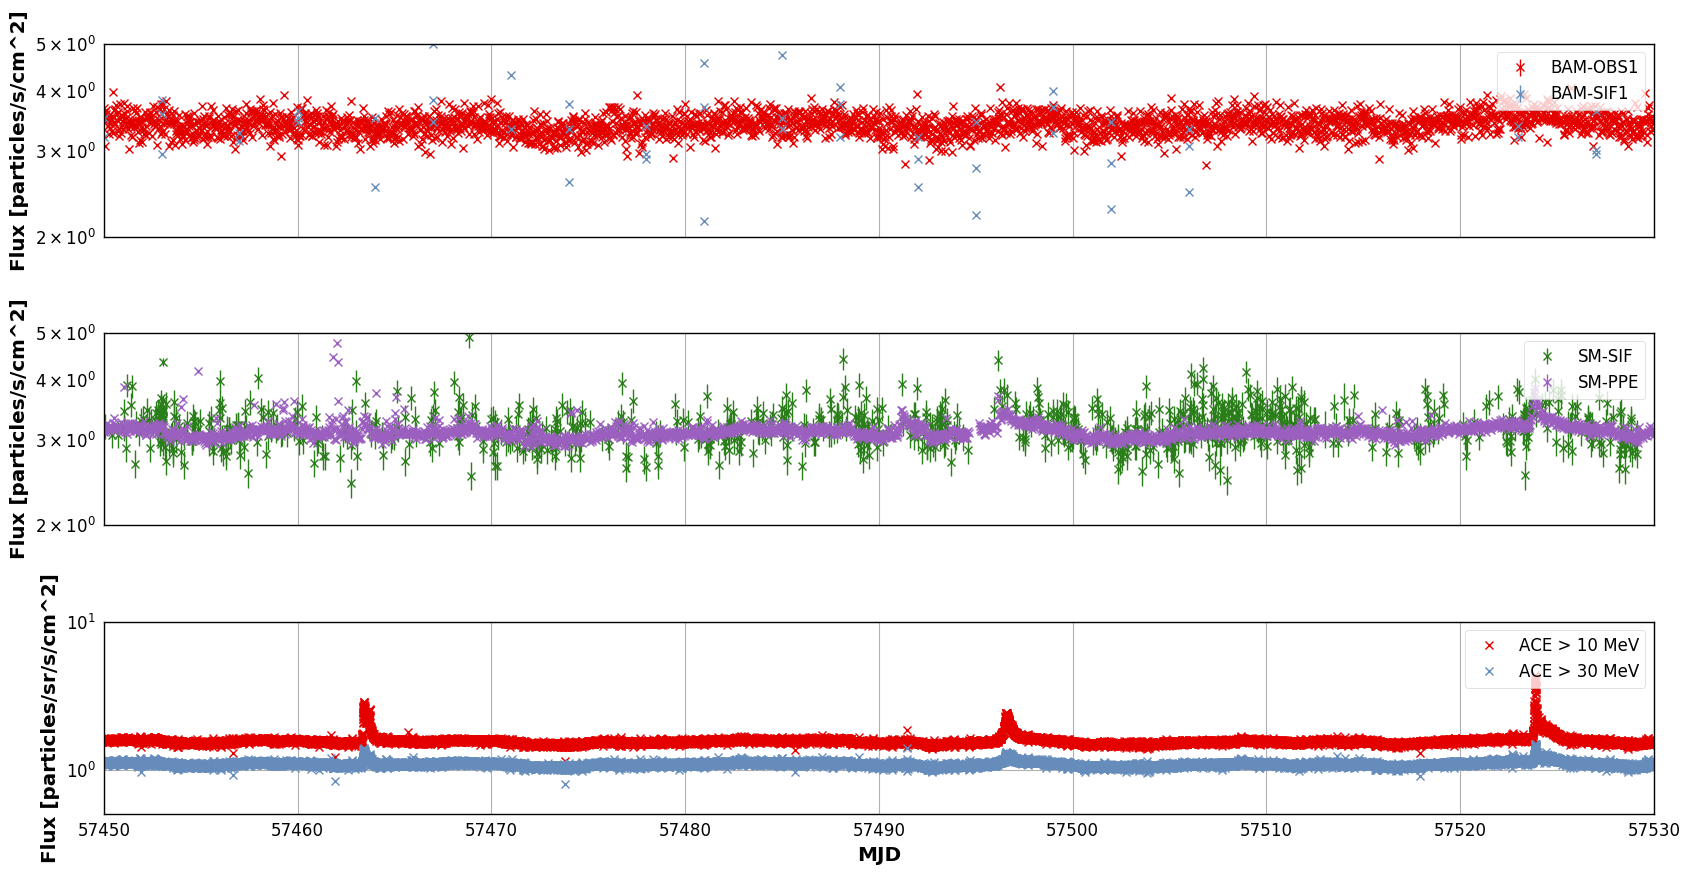

In [89]:
flareplot(57450,57530,10,ybam=(2,5),ysm=(2,5),yext=(.5,10))

Again curious to see when something is picked up or not

## 57600 - 57800

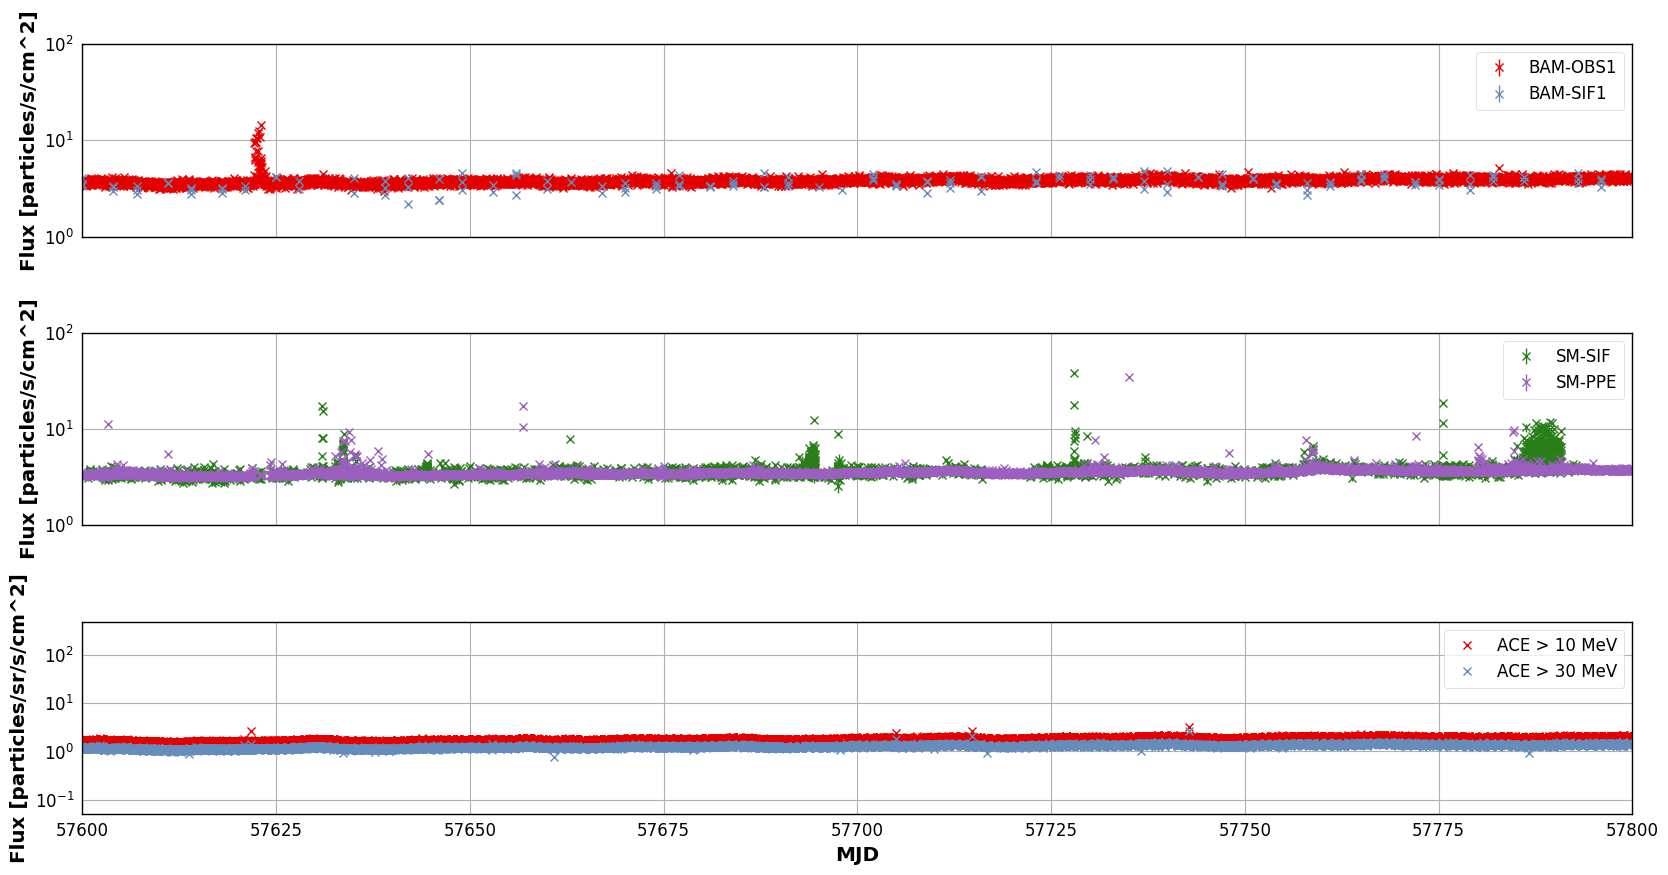

In [24]:
flareplot(57600,57800,10)

## 57800 - 58000

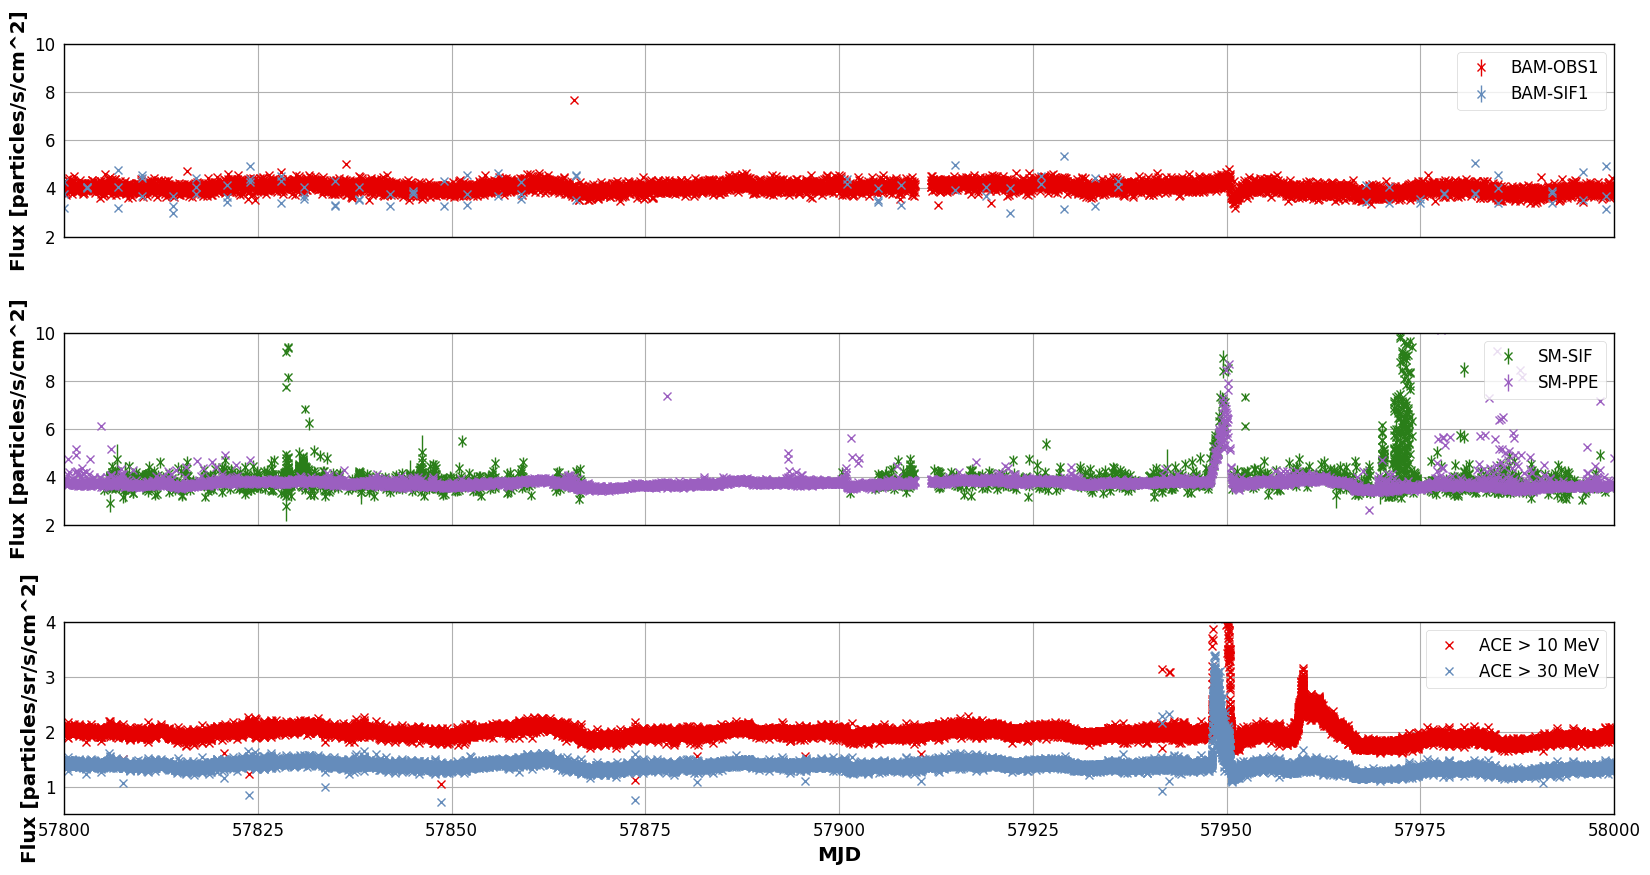

In [139]:
flareplot(57800,58000,10)

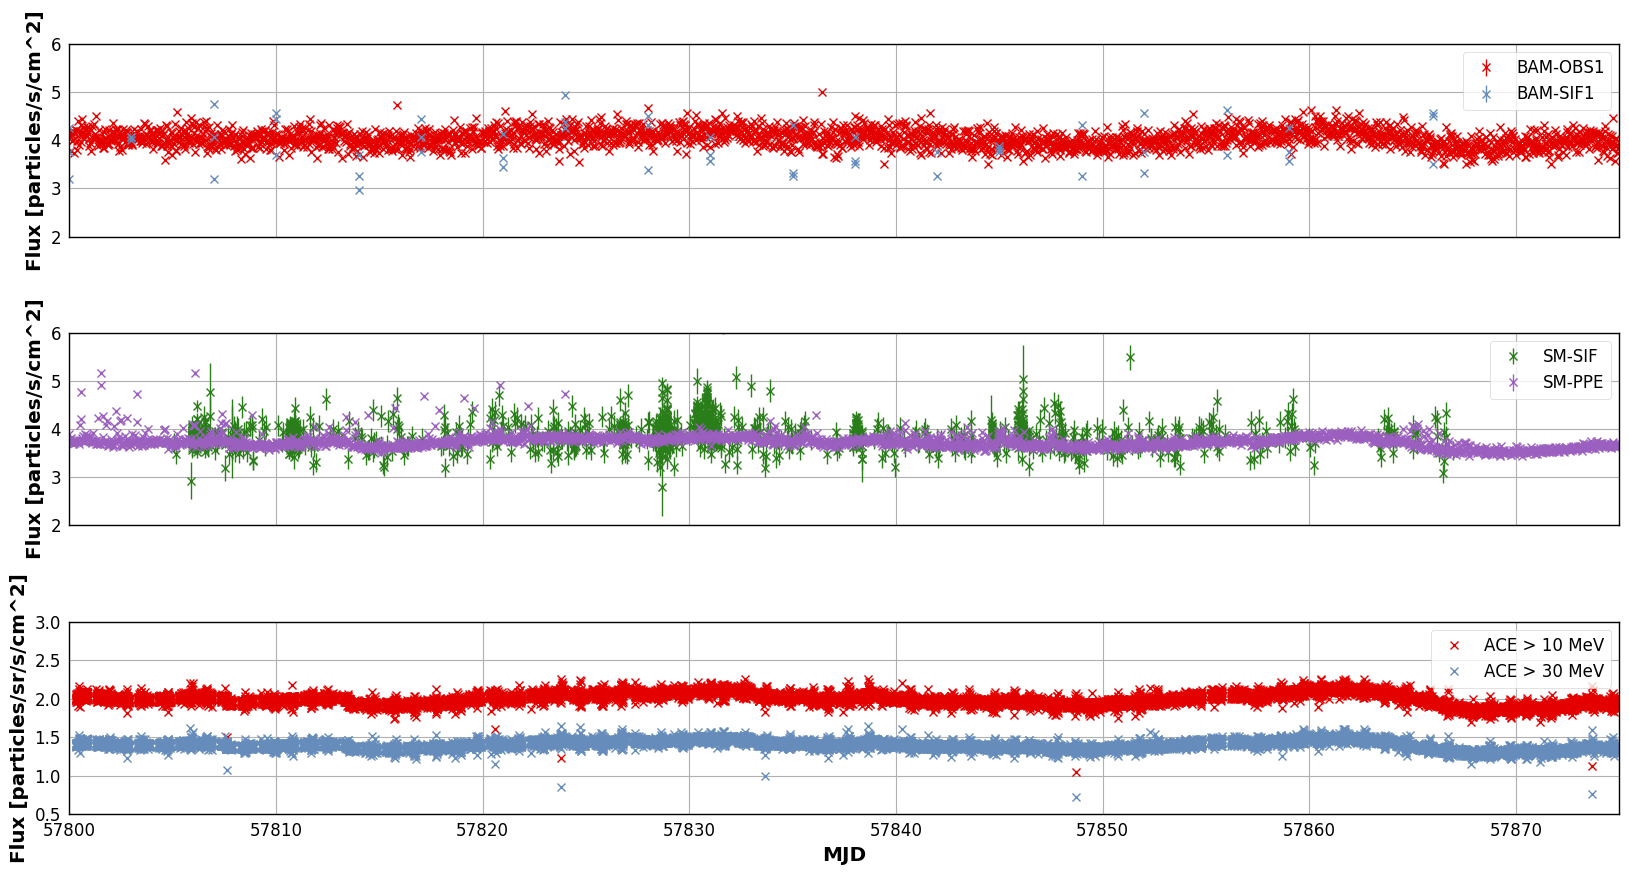

In [141]:
flareplot(57800,57875,10,ybam=(2,6),ysm=(2,6),yext=(.5,3),log=False)

Interesting here: There is some modulation from 57800 to 57875 that's perfectly matched by BAM

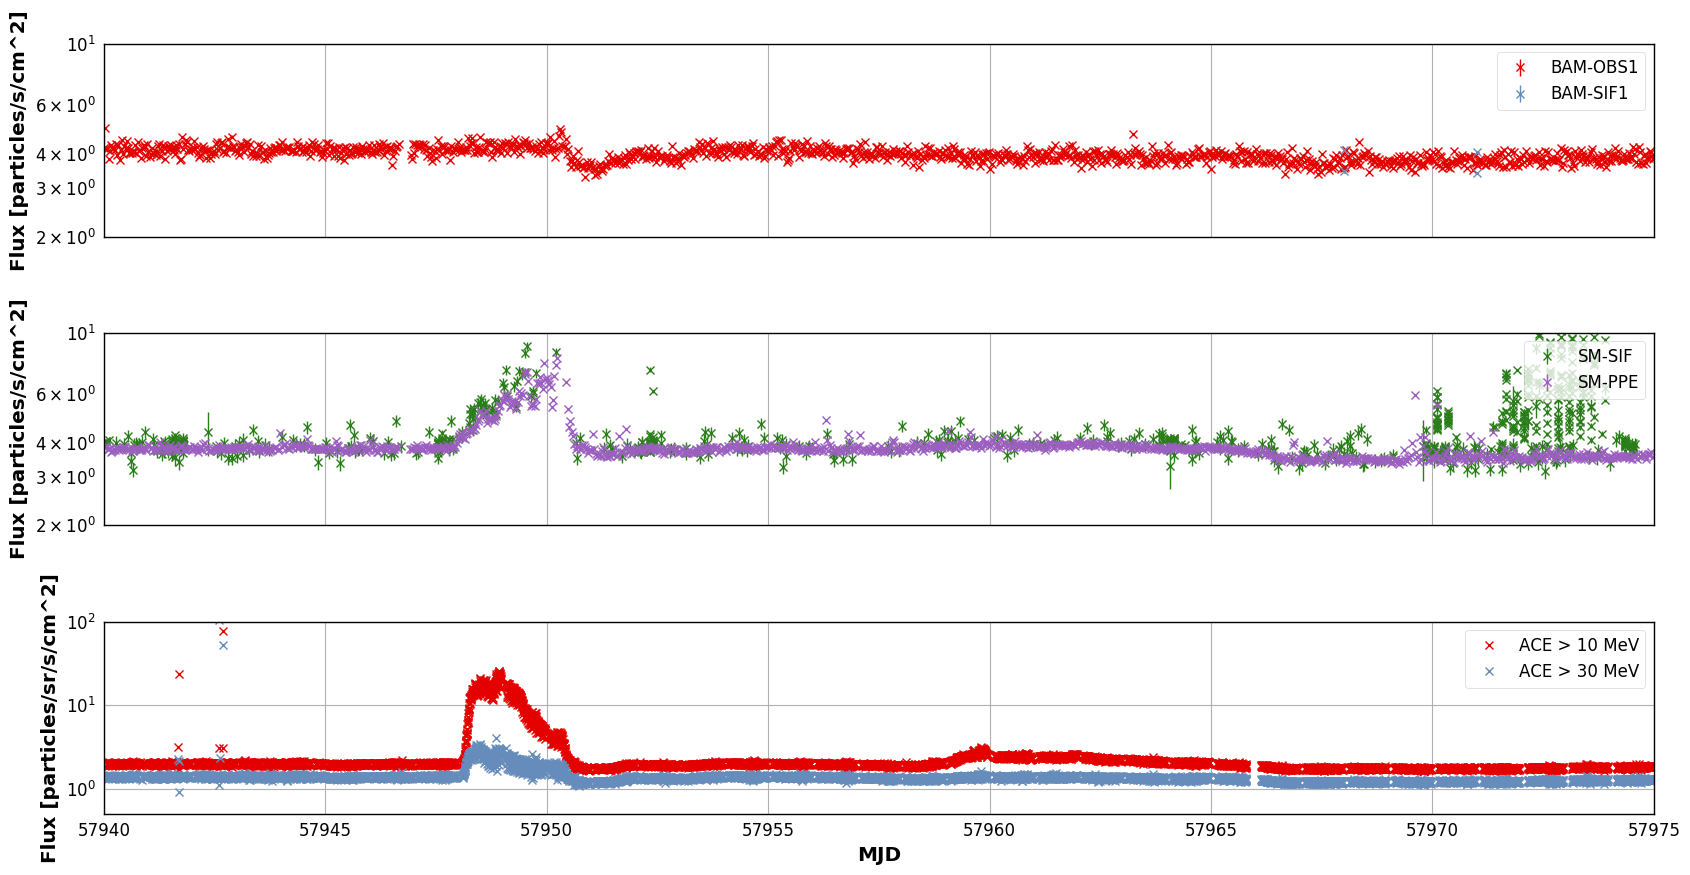

In [90]:
flareplot(57940,57975,10,ybam=(2,10),ysm=(2,10),yext=(.5,100))

Kink in BAM after the flare

## 58000 - NOW

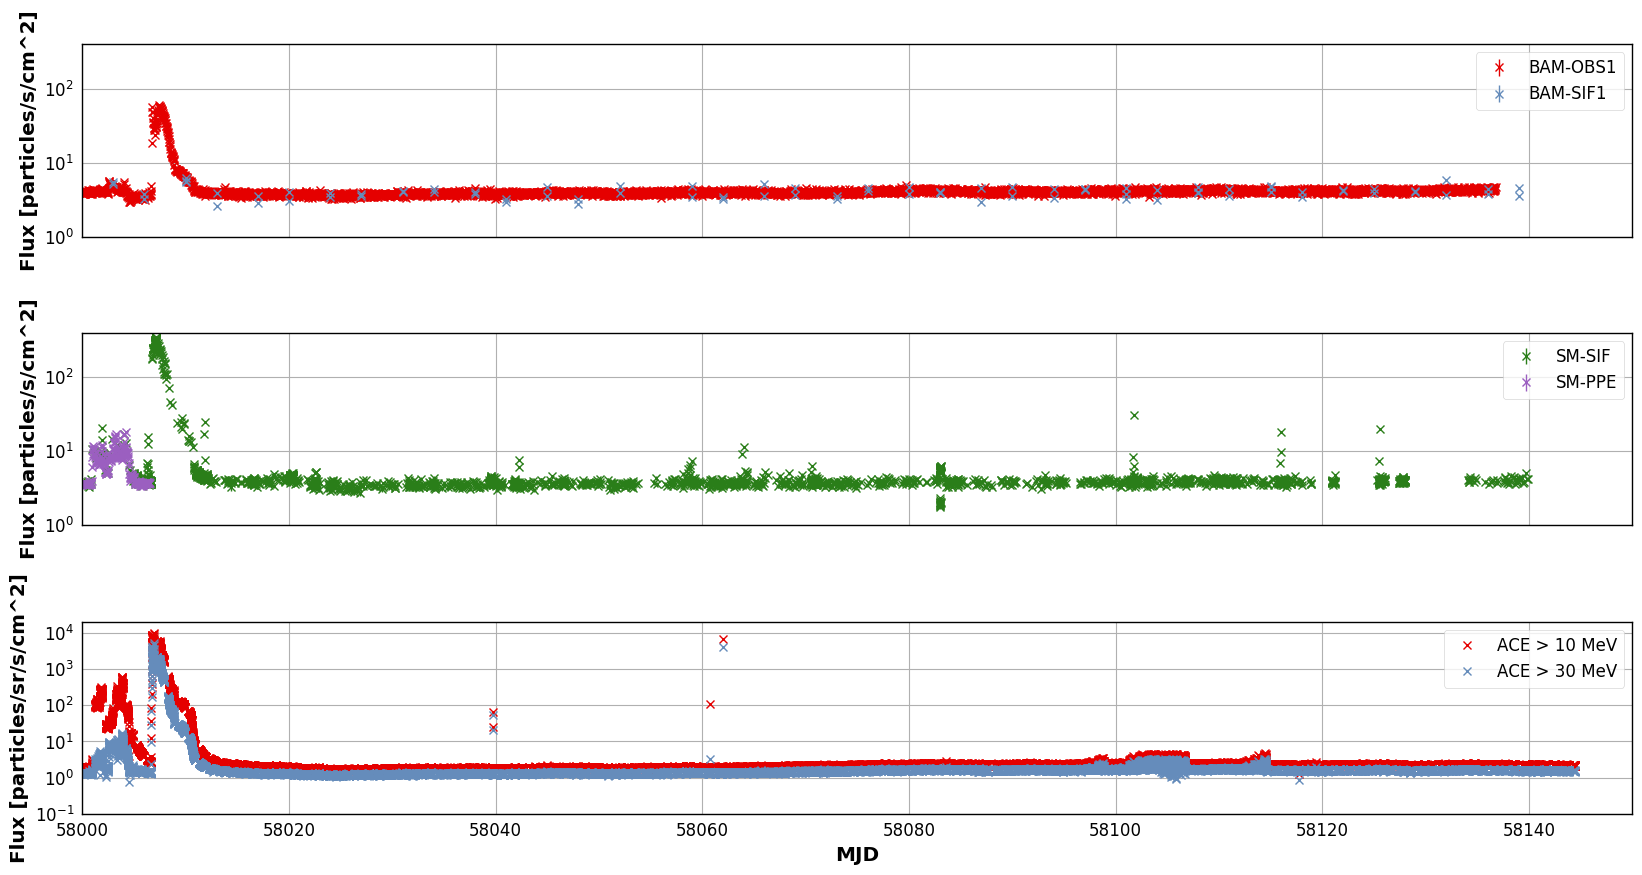

In [125]:
flareplot(58000,58150,10,ybam=(1,400),ysm=(1,400),yext=(.1,20000))

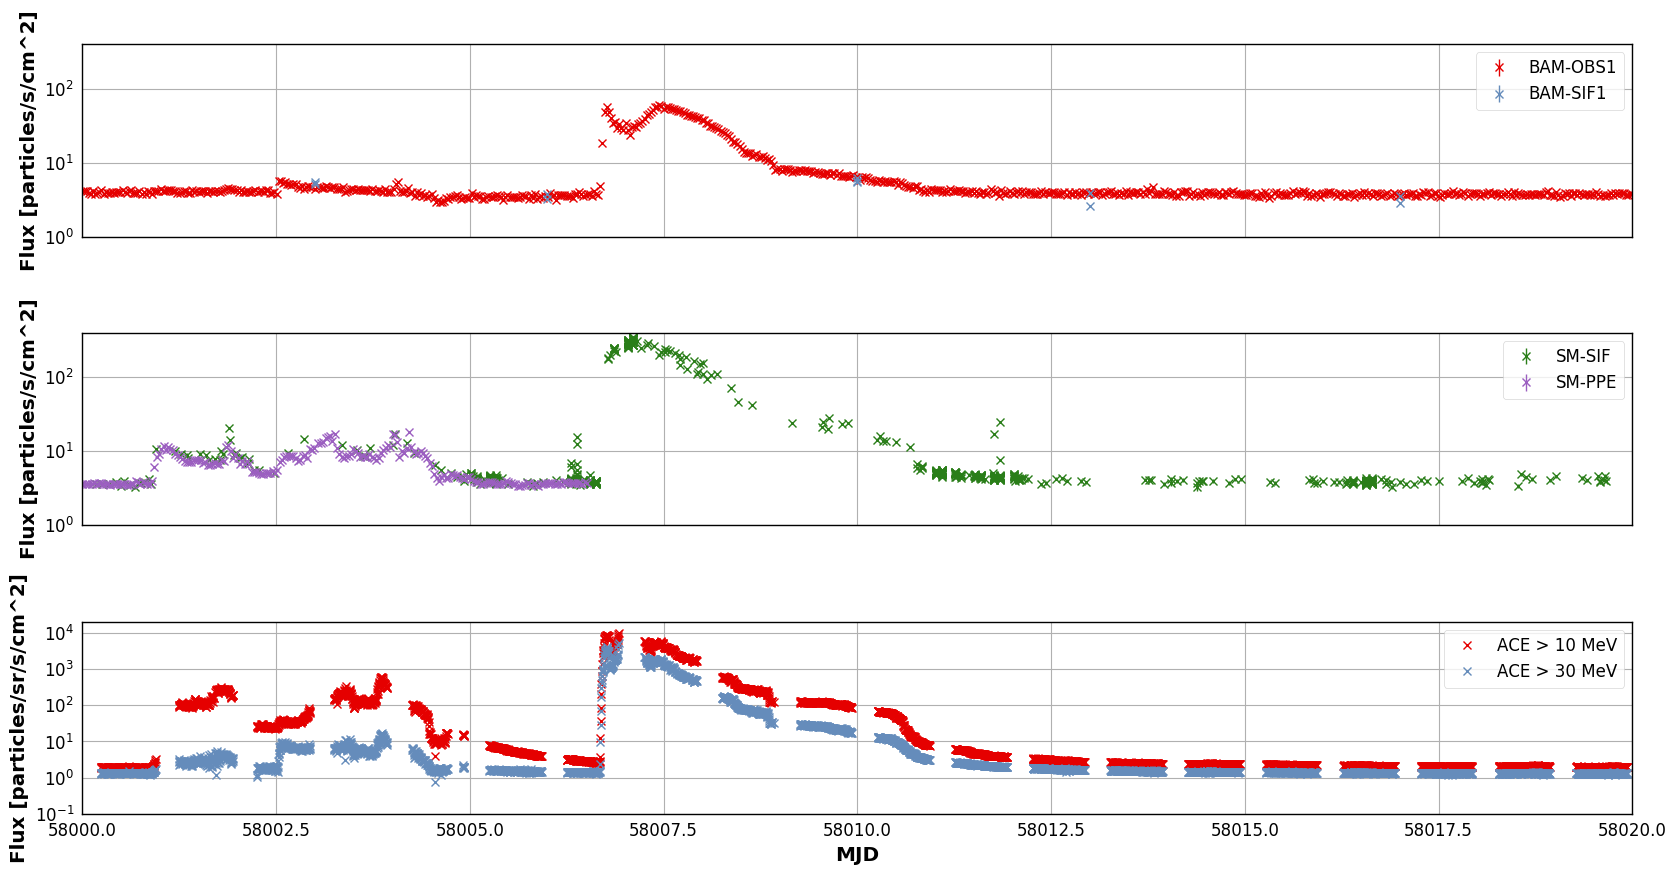

In [41]:
# September 2017
flareplot(58000,58020,10,ybam=(1,400),ysm=(1,400),yext=(.1,20000))

Very interesting precursor. BAM is totally overwhelmed during the flare proper, but we do see some of the kinks in the ACE data as well.

# Frequency modulations

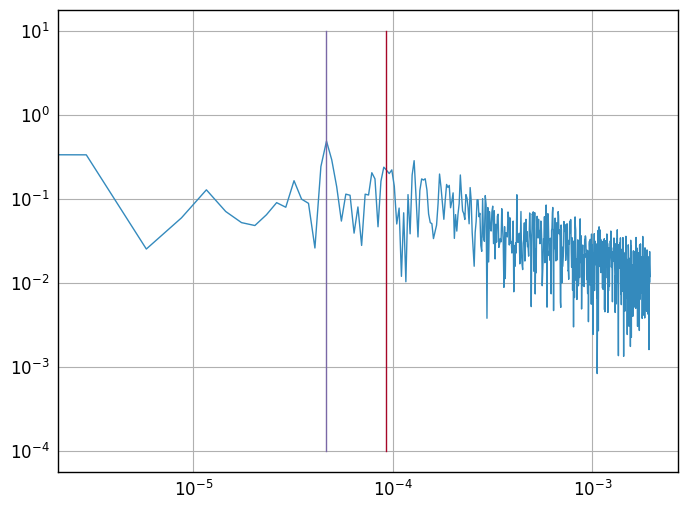

In [142]:
# what do we get from an fft of these fluxes?

from scipy.fftpack import fft

#tstart,tstop = (57930,57945) # quiet period
tstart,tstop = (57632,57636) # strong stray light modulation

#t,f,err = MJD_cutout(t_B1_full,f_B1_full,err_B1_full,tstart,tstop)
t,f,err = MJD_cutout(t_P,f_P,err_P,tstart,tstop)


N = len(t)

# sample spacing

T = (t[1]-t[0]) * 86400 # MJD -> Seconds

y_fft = fft(f)
x_fft = np.linspace(0,1/(2*T), N//2)

plt.plot(x_fft, 2/N * np.abs(y_fft[0:N//2]))

plt.xscale("log")
plt.yscale("log")

plt.plot(np.ones(500)/(6*3600), np.linspace(1e-4,10,500)) # should be 6 hours
plt.plot(np.ones(500)/(3*3600), np.linspace(1e-4,10,500)) # should be 3 hours